<a href="https://colab.research.google.com/github/burrittresearch/stock-market-forecasting-in-python/blob/main/stock-market-forecasting-in-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Forecasting in Python
This notebook includes coding and notes for predicting prices of financial market assets including stocks, ETFs, and indices. A single class object was created to provide informational, cleaning, modeling, and visualization functions for processing financial asset data and predicting prices. Then all the available methods were run. Source data is downloaded using the [yfinance module](https://pypi.org/project/yfinance).

# Project Workflow
* Define the Problem
* Process Data
* Class Object AssetData Cleans, Models, and Visualizes Financial Data
* Run all Class Methods

# Define the Problem
Predict the future price of financial market assets including stocks, ETFs, and indices.

# Process Data

In [18]:
# Import libraries
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score,
  classification_report,
  confusion_matrix,
  f1_score,
  mean_squared_error, precision_score,
  r2_score
)
from sklearn.model_selection import train_test_split

# Install and import yfinance
!pip install yfinance
import yfinance as yf
pd.Series(dtype='float64')

Series([], dtype: float64)

In [2]:
# Set display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 3)

# Line break utility
str_lb = '\n \n'

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Class Object *AssetData* Cleans, Models, and Visualizes Financial Data

In [4]:
class AssetData:

  """
  Provides various informational, cleaning, modeling, and visualization functions for processing financial asset data
  and predicting prices. Source data is downloaded from yfinance and then processed.

  Parameters
  ----------
  str_co_ticker : str, required
    Any valid asset symbol.

  str_period : str, required, default 'max'
    Time duration for data.
    Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

  str_interval : str, required, default '1d'
    Time interval for data.
    Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

  update : bool, required, default False
    If True will download latest data and update csv file.
    If False will not download latest file data and will not update csv file.

  tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
     Tuple of valid intervals to run model.

  Methods
  ----------
  get_ticker
    Returns the asset ticker.

  get_period
    Returns the data time duration.

  get_interval
    Returns the data time interval.

  download_csv
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. Then looks to __init__ method for update. If file already exists and update argument is False,
    then existing file is not updated. If File already exists and update argument is True, then existing file is updated.
    If file doesn't exist, it is downloaded. Prints message indicating operations that were performed.

  get_raw_dataframes
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes. Returns the raw dataframe.

  explore_raw_dataframes
    Runs get_raw_dataframe and then prints basic dataframe information.

  get_clean_dataframes
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms.

  get_visual_data
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms,
    and regplots.

  run_class_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports)
    and dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints
    dataframe and visualization.

  run_class_model_list
    Runs run_class_model for a tuple of asset tickers.

  run_mlr_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints
    dataframe and visualization.

  run_mlr_model_list
    Runs run_mlr_model for a tuple of asset tickers.

  Example
  ----------
  AssetData('ibm').get_ticker()

  """

  def __init__(self, str_co_ticker, str_period='max', str_interval='1d', update=False,
    tpl_model_intervals=('1d', '1wk', '1mo')):

    """
    Initializes the class

    Parameters
    ----------
    str_co_ticker : str, required
    Any valid asset symbol.

    str_period : str, required, default 'max'
      Time duration for data.
      Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

    str_interval : str, required, default '1d'
      Time interval for data.
      Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

    update : bool, required, default False
      If True will download latest data and update csv file.
      If False will not download latest file data and will not update csv file.

    tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
      Tuple of valid intervals to run model.

    NOTE: Data is downloaded to csv from yfinance given above paramters.
          Data is stored is default drive location indicated below.

    """
    # Creates attributes for the class
    self.str_co_ticker = str_co_ticker
    self.str_period = str_period
    self.str_interval = str_interval
    self.str_drive_loc = '/content/drive/MyDrive/Colab Notebooks/input/'
    self.update = update
    self.tpl_model_intervals = list(tpl_model_intervals)
    self.lst_features_plots = ['open',
      'high',
      'low',
      'close',
      'volume',
      'target_price',
      'target_class'
    ]

    self.lst_features_model = ['open',
      'high',
      'low',
      'close',
      'volume',
      # 'target_price',
      # 'target_class'
    ]

    # Sets font paramters
    self.global_font = 10
    self.local_font = 12

  def get_ticker(self):

    """
    Gets the asset ticker.

    Returns
    ----------
    Ticker symbol.

    """

    return self.str_co_ticker

  def get_period(self):

    """
    Gets the data time period duration.

    Returns
    ----------
    Time period duration.

    """

    return self.str_period

  def get_interval(self):

    """
    Gets the data time interval.

    Returns
    ----------
    Time interval.

    """

    return self.str_interval

  def download_csv(self):

    """
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. If file already exists and update argument is False, then existing file is not updated. If File
    already exists and update argument is True, then existing file is updated. If file doesn't exist, it is downloaded.
    Prints message indicating operations that were performed.

    """

    update = self.update

    # Assigns varible for file path and checks if it exists
    str_save_to_input = (self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' +
      self.str_interval + '.csv')

    if Path(str_save_to_input).exists() is True and update is True:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)

    elif Path(str_save_to_input).exists() is True and update is False:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: NO{str_lb}')

    elif Path(str_save_to_input).exists() is False:
      print(f'FILE DOES NOT EXIST: {str(Path(str_save_to_input))} DOWNLOADED: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)

    return

  def get_raw_dataframes(self):

    """
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes.
    Returns the raw dataframe.

    Returns
    ----------
    Raw dataframe.

    """
    # Runs download_csv method
    self.download_csv()

    # Assigns variable and gets raw dataframe
    str_save_to_input = (self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' +
      self.str_interval + '.csv')
    df = pd.read_csv(str_save_to_input, index_col=['Date'], parse_dates=['Date'])

    return df

  def explore_raw_dataframes(self):

    """
    Runs get_raw_dataframe and then prints basic dataframe information.

    """
    # Assigns variable and runs get_raw_dataframes method
    df = self.get_raw_dataframes()

    # Explore data
    df.info()

    # Prints dataframe information
    print(f'df.head(): {str_lb}{df.head()}{str_lb}',
      f'df.shape: {str_lb}{df.shape}{str_lb}',
      f'df.describe(): {str_lb}{df.describe()}{str_lb}',
      f'df.corr(method="pearson"): {str_lb}{df.corr(method="pearson")}{str_lb}'
    )

    return

  def get_clean_dataframes(self):

    """
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms.

    """
    # Assigns variable and runs get_raw_dataframes method
    df = self.get_raw_dataframes()

    # Drops and renames columns, renames index
    df.drop(['Adj Close'], axis=1, inplace=True)
    dict_rename = ({'Open':'open',
      'High':'high',
      'Low':'low',
      'Close':'close',
      'Volume':'volume',
    })
    df.rename(columns=dict_rename, inplace=True)
    df.index.rename('date', inplace=True)

    # Create target price and target class price from next period's close
    df['target_price'] = df['close'].shift(-1)
    df['target_class'] = np.where(df.target_price > df.close, 1, 0)

    # Slices the dataframe up one period to avoid target price null calculation
    df = df.iloc[:-1]

    # Copies dataframe
    df = df.copy()

    return df

  def get_visual_data(self):

    """
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms,
    and regplots.

    """

    # Sets plot options
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")

    # Assigns global font size
    plt.rcParams['font.size'] = self.global_font

    # Assigns variable and runs get_raw_dataframes method
    df = self.get_clean_dataframes()

    # Creates line plot and correlation heatmap
    fig = plt.figure(figsize=(13.6, 4))
    fig.subplots_adjust(wspace=0.50, hspace=0.50)

    # Creates price line plot
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(df.close, label='Close')
    ax.set_title(f'Price', fontsize=self.local_font)
    ax.legend(loc='upper left')

    # Creates correlation heatmap
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f'Feature Correlation Heatmap', fontsize=self.local_font)
    sns.heatmap(df.corr(method = 'pearson'), cmap='Oranges', center=1, annot=True, fmt='.2f', linewidth=0.5)
    fig.suptitle(f'{str_lb}MODEL ASSET: {self.str_co_ticker}  PERIOD: {self.str_period} INTERVAL: {self.str_interval}',
      y=1.10, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Assigns number of records to visualize pairplot
    int_rows = 10

    # Creates pairplot of features list
    sns.set(font_scale=0.75)
    ax = sns.pairplot(df[-int_rows:], hue='target_price', vars=self.lst_features_plots, diag_kind='kde')
    ax.fig.set_size_inches(11.9, 7)
    ax.fig.suptitle(f'Feature and Target Pairplots (Records: {int_rows})', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Creates histograms of features list
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))

    for int_index, str_feature in enumerate(self.lst_features_plots):

      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      ax.hist(df[str_feature], bins=50, color='green', edgecolor='black')
      ax.set_title(str_feature, fontsize=self.local_font)
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Histograms', y=1.10, fontsize=self.local_font)

    plt.show()
    print(str_lb)

    # Creates regplots of features and target
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))

    for int_index, str_feature in enumerate(self.lst_features_plots):

      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      sns.regplot(x=df[str_feature], y=df['target_price'], color='blue', line_kws={'color': 'red', 'lw': 3})
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Regplots', y=1.10, fontsize=self.local_font)

    plt.show()

    return

  def run_class_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints
    dataframe and visualization.

    Parameters
    ----------
    bool_get_reports : bool, default True
      If True will print various evaluation reports.

    bool_get_dfs : bool, default True
      If True, will print evaluation dataframes.
    ----------

    """

    # Creates lists for scores
    lst_int = []
    lst_flt_accuracy_score = []
    lst_f1_score = []
    lst_flt_precision_score = []
    lst_flt_score = []

    # Creates list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loops through intervals and run model
    for interval in self.tpl_model_intervals:

      # Assigns an interval to class attribute
      self.str_interval = interval

      # Checks for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_class_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Prints model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Gets clean dataframe for model
      df = self.get_clean_dataframes()

      # Creates the training and test sets
      X = df[self.lst_features_model]
      y = df.target_class

      # Manually splits sets by date to avoid leakage and then randomize
      flt_train_pct = 0.70
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Creatse the model using random forest classification
      rf_model_price_data = RandomForestClassifier()

      # Trains the model
      rf_model_price_data.fit(X_train, y_train)

      # Predicts asset values for the test set
      y_hat = rf_model_price_data.predict(X_test)

      # Creates new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_class'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluates the results
      flt_accuracy_score = accuracy_score(y_test, y_hat)
      flt_f1_score = f1_score(y_test, y_hat, average='macro')
      flt_precision_score = precision_score(y_test, y_hat)
      flt_score = rf_model_price_data.score(X_test, y_test)

      # Creates lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_accuracy_score.append(flt_accuracy_score)
      lst_f1_score.append(flt_f1_score)
      lst_flt_precision_score.append(flt_precision_score)
      lst_flt_score.append(flt_score)

      # Creates dictionary to store evaluation results
      dict_scores = {'lst_flt_accuracy_score':lst_flt_accuracy_score,
        'lst_f1_score':lst_f1_score,
        'lst_flt_precision_score':lst_flt_precision_score,
        'lst_flt_score':lst_flt_score
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Classification Report:{str_lb}{classification_report(y_test, y_hat, zero_division=1)}{str_lb}')

        # Plot the results
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        arr_conf_matrix = confusion_matrix(df_pred.target_class, df_pred.target_pred)
        sns.heatmap(arr_conf_matrix, cmap='Greens', center=1, annot=True, fmt='.1f', linewidth=0.5, xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        ax.set_xlabel('Predicted Classification')
        ax.set_ylabel('Actual Classification')
        ax.set_title(f'Predicted vs Actual Asset Values Classification Model Confusion Matrix{str_lb}MODEL ASSET: {self.str_co_ticker} '
          f'PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: First 20 Records{str_lb}{df_pred.head(20)}{str_lb}')
        print(f'Feature, Target and Prediction Comparison: Last 20 Records{str_lb}{df_pred.tail(20)}{str_lb}')

        str_save_to_input_pred = self.str_drive_loc + self.str_co_ticker  + '-target-vs-pred-class-' + self.str_period + '-' + self.str_interval + '.csv'
        df_pred.to_csv(str_save_to_input_pred)
        print(f'Output Target vs Predictions to csv: {str_lb}{str_save_to_input_pred}{str_lb}')

    # Prints a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualizes summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 4))
    ax = fig.add_subplot()
    df_score_comp_class.plot(kind='bar', ax=ax)
    ax.set_title(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', fontsize=self.local_font)
    ax.legend(loc='upper left')
    plt.show()
    print(str_lb)

    return

  def run_class_model_list(self, tpl_assets):

    """
    Runs run_class_model for a tuple of asset tickers.

    """

    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)

    for asset in lst_assets:
       self.str_co_ticker = asset
       print(self.run_class_model())

    return

  def run_mlr_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints
    dataframe and visualization.

    """

    # Creates lists for scores
    lst_int = []
    lst_flt_score = []
    lst_flt_r2_score = []
    lst_flt_mse = []

    # Creates list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loops through intervals and run model
    for interval in self.tpl_model_intervals:

      # Assigns an interval to class attribute
      self.str_interval = interval

      # Checks for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_mlr_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Prints model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Gets clean dataframe for model
      df = self.get_clean_dataframes()

      # Creates the training and test sets
      X = df[self.lst_features_model]
      y = df.target_price

      # Manually splits sets by date to avoid leakage and then randomize
      flt_train_pct = 0.75
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Creates the model using multiple linear regression
      mlr_model_price_data = LinearRegression()

      # Trains the model
      mlr_model_price_data.fit(X_train, y_train)

      # Predicts asset values for test set
      y_hat = mlr_model_price_data.predict(X_test)

      # Creates new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_price'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluates the results
      flt_score = mlr_model_price_data.score(X_test, y_test)
      flt_r2_score = r2_score(y_test, y_hat)
      flt_mse = mean_squared_error(y_test, y_hat)

      # Creates lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_score.append(flt_score)
      lst_flt_r2_score.append(flt_r2_score)
      lst_flt_mse.append(flt_mse)

      # Creates dictionary to store evaluation results
      dict_scores = {'lst_flt_score':lst_flt_score,
        'lst_flt_r2_score':lst_flt_r2_score,
        'lst_flt_mse':lst_flt_mse,
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Model Coefficents: {str_lb}{mlr_model_price_data.coef_}{str_lb}')
        print(f'Model Intercept: {str_lb}{mlr_model_price_data.intercept_}{str_lb}')

        # Plot the results
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        x = df_pred.index
        y = df_pred.target_price
        y_hat = df_pred.target_pred
        ax.plot(x, y, color='g', label='target_price', linestyle='-', linewidth=2)
        ax.plot(x, y_hat, color='b', label='target_pred', linestyle=':', linewidth=5)
        ax.set_title(f'Predicted vs Actual Asset Values Using Multiple Regression{str_lb}MODEL ASSET: {self.str_co_ticker} '
          f'PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        ax.legend(loc='upper left')
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: First 20 Records{str_lb}{df_pred.head(20)}{str_lb}')
        print(f'Feature, Target and Prediction Comparison: Last 20 Records{str_lb}{df_pred.tail(20)}{str_lb}')

        str_save_to_input_pred = self.str_drive_loc + self.str_co_ticker  + '-target-vs-pred-regr-' + self.str_period + '-' + self.str_interval + '.csv'
        df_pred.to_csv(str_save_to_input_pred)
        print(f'Output Target vs Predictions to csv: {str_lb}{str_save_to_input_pred}{str_lb}')


    # Prints a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualizes summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 6))
    ax = fig.add_subplot(3, 1, 1)
    df_score_comp_class.loc['lst_flt_score':'lst_flt_r2_score'].plot(kind='bar', ax=ax)
    ax.legend(loc='upper left')
    ax = fig.add_subplot(3, 1, 3)
    df_score_comp_class.loc['lst_flt_mse':'lst_flt_mse'].plot(kind='bar', ax=ax)
    ax.legend(loc='upper left')
    fig.suptitle(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    return

  def run_mlr_model_list(self, tpl_assets):

    """
    Runs run_mlr_model for a tuple of asset tickers.

    """
    # Creates of list of assets
    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)

    # Loops through asset list and runs run_mlr_model method
    for asset in lst_assets:
      self.str_co_ticker = asset
      print(self.run_mlr_model())

    return



# Assign Asset Variables to Run All Methods

In [5]:
str_co_ticker_1 = '^IXIC'
str_co_ticker_2 = 'ibm'

# Method get_ticker

In [6]:
AssetData(str_co_ticker_1).get_ticker()

'^IXIC'

# Method get_period

In [7]:
AssetData(str_co_ticker_1).get_period()

'max'

# Method get_interval

In [8]:
AssetData(str_co_ticker_1).get_interval()

'1d'

# Method download_csv

In [9]:
AssetData(str_co_ticker_2).download_csv()

FILE DOES NOT EXIST: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv DOWNLOADED: YES
 



[*********************100%%**********************]  1 of 1 completed


# Method get_raw_dataframes

In [10]:
AssetData(str_co_ticker_1).get_raw_dataframes()


FILE DOES NOT EXIST: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv DOWNLOADED: YES
 



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.00,100.000,100.00,100.000,100.000,0
1971-02-08,100.84,100.840,100.84,100.840,100.840,0
1971-02-09,100.76,100.760,100.76,100.760,100.760,0
1971-02-10,100.69,100.690,100.69,100.690,100.690,0
1971-02-11,101.45,101.450,101.45,101.450,101.450,0
...,...,...,...,...,...,...
2024-01-30,15604.08,15619.230,15484.67,15509.900,15509.900,4719240000
2024-01-31,15324.19,15405.560,15158.49,15164.010,15164.010,5875610000
2024-02-01,15254.02,15372.130,15208.88,15361.640,15361.640,5046920000


# Method explore_raw_dataframes

In [11]:
AssetData(str_co_ticker_1).explore_raw_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13365 entries, 1971-02-05 to 2024-02-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       13365 non-null  float64
 1   High       13365 non-null  float64
 2   Low        13365 non-null  float64
 3   Close      13365 non-null  float64
 4   Adj Close  13365 non-null  float64
 5   Volume     13365 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 730.9 KB
df.head(): 
 
            Open    High    Low     Close   Adj Close  Volume
Date                                                         
1971-02-05  100.00  100.00  100.00  100.00  100.00     0     
1971-02-08  100.84  100.84  100.84  100.84  100.84     0     
1971-02-09  100.76  100.76  100.76  100.76  100.76     0     
1971-02-10  100.69  100.69  100.69  100.69  100.69     0     
1971-02-11  101.4

# Method get_clean_dataframes

In [12]:
AssetData(str_co_ticker_1).get_clean_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 



,open,high,low,close,volume,target_price,target_class
date,,,,,,,
1971-02-05,100.00,100.00,100.00,100.00,0,100.840,1
1971-02-08,100.84,100.84,100.84,100.84,0,100.760,0
1971-02-09,100.76,100.76,100.76,100.76,0,100.690,0
1971-02-10,100.69,100.69,100.69,100.69,0,101.450,1
1971-02-11,101.45,101.45,101.45,101.45,0,102.050,1
...,...,...,...,...,...,...,...
2024-01-29,15470.66,15630.58,15449.87,15628.04,4979310000,15509.900,0
2024-01-30,15604.08,15619.23,15484.67,15509.90,4719240000,15164.010,0
2024-01-31,15324.19,15405.56,15158.49,15164.01,5875610000,15361.640,1


# Method get_visual_data

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 



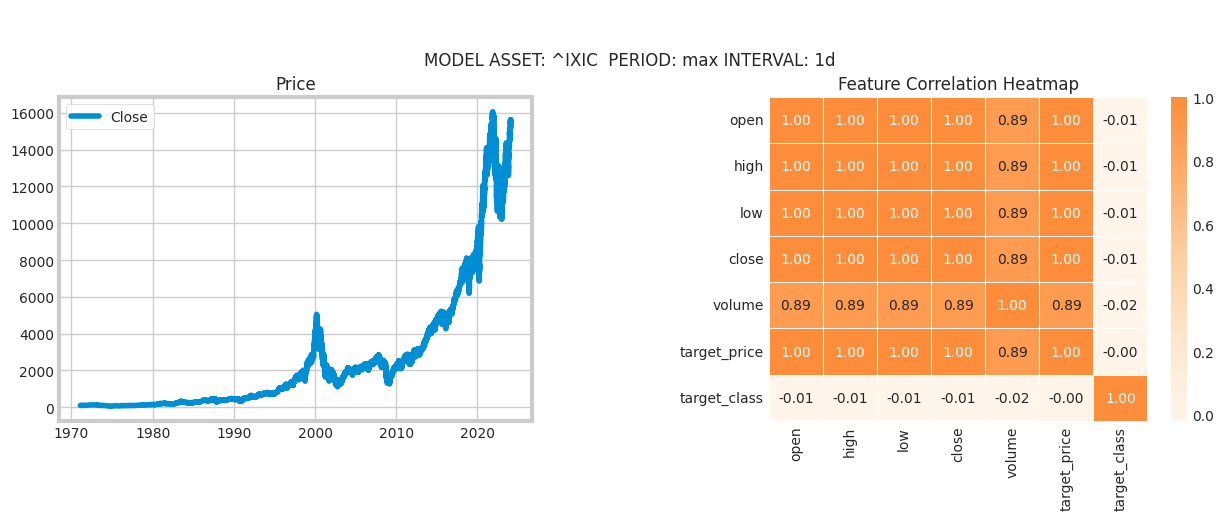

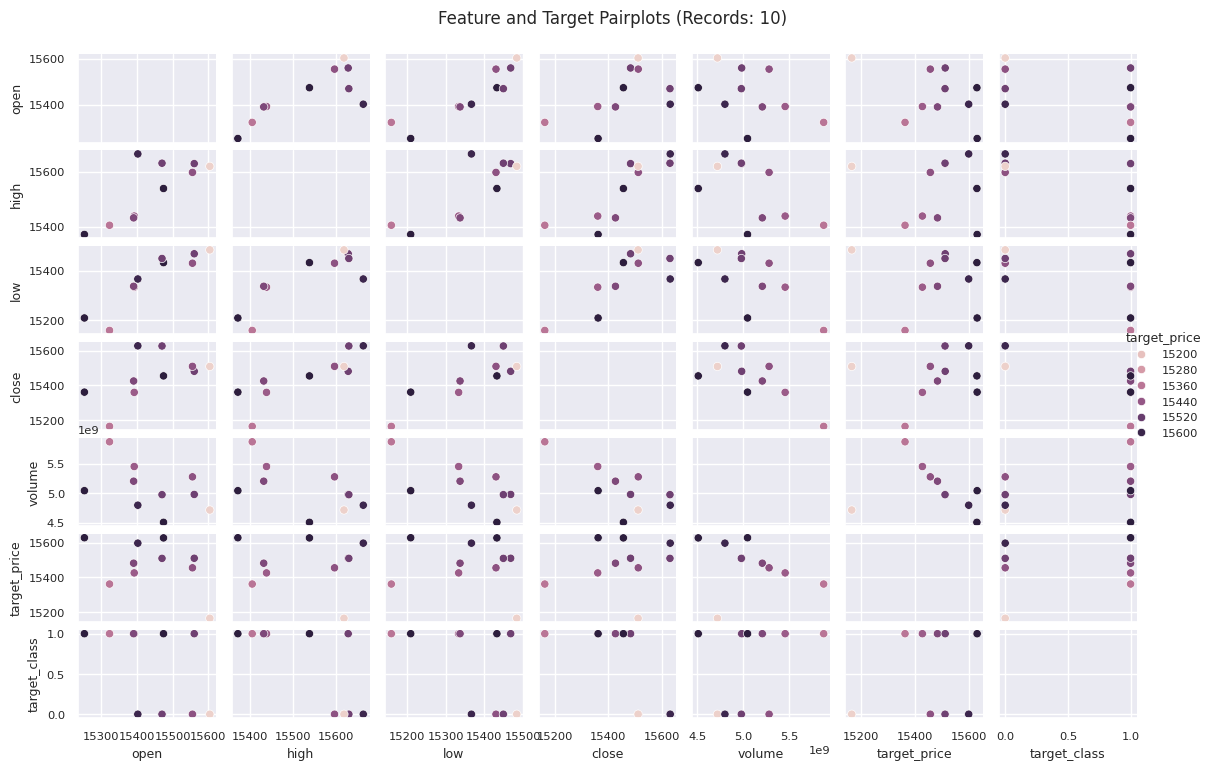

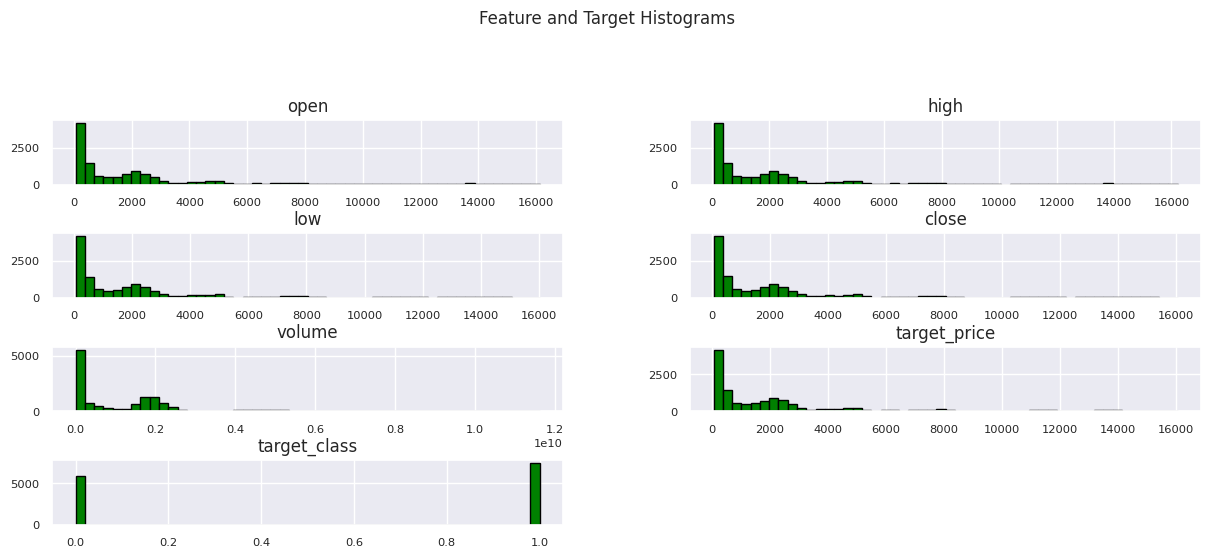

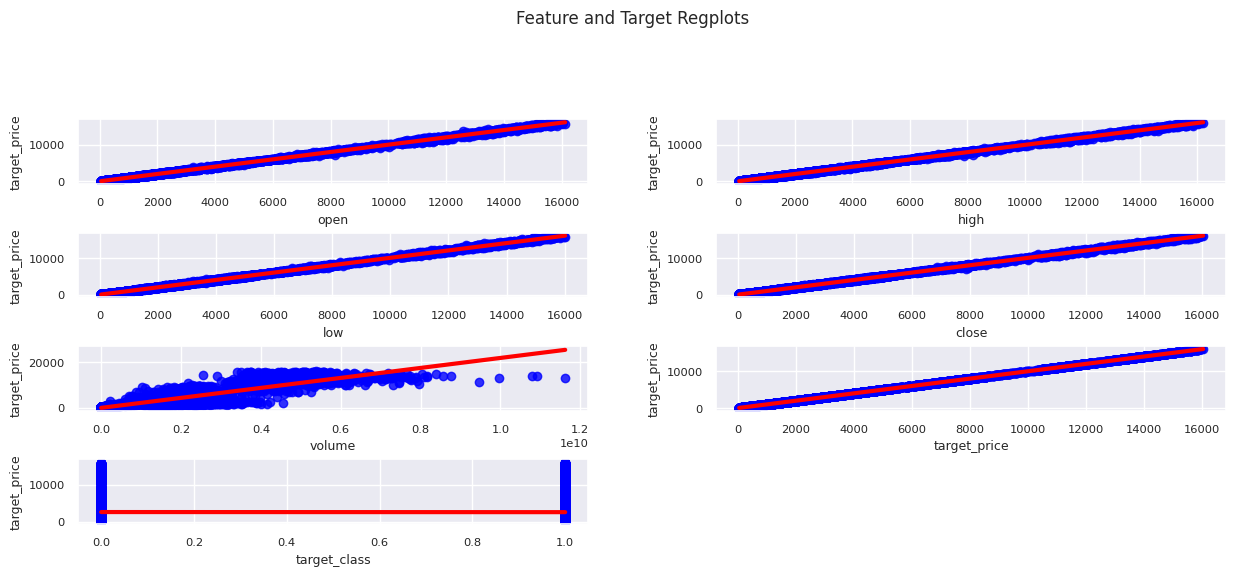

In [13]:
AssetData(str_co_ticker_1).get_visual_data()

# Method run_class_model


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.45      0.77      0.57      1795
           1       0.57      0.24      0.34      2215

    accuracy                           0.48      4010
   macro avg       0.51      0.51      0.45      4010
weighted avg       0.51      0.48      0.44      4010

 



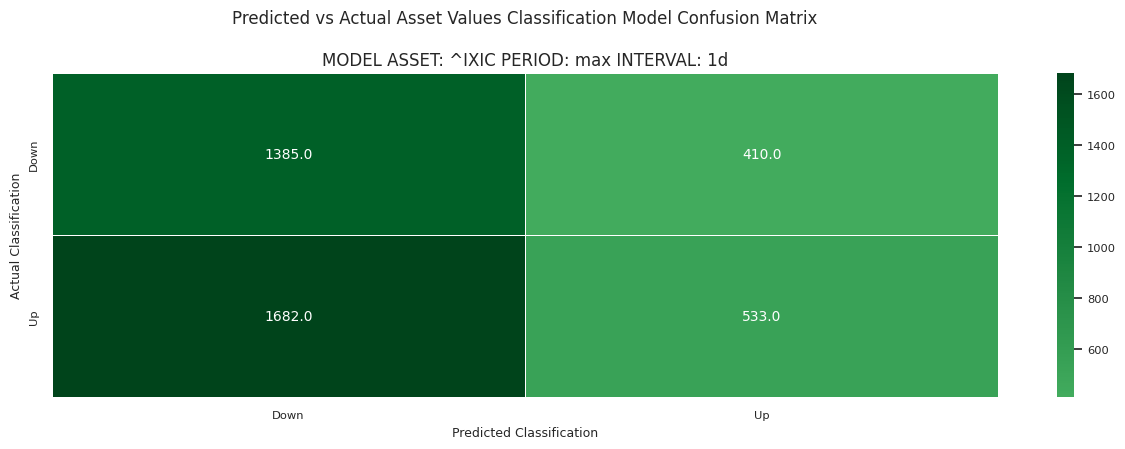


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume      target_class  target_pred
date                                                                                 
2008-02-29  2309.06  2311.23  2264.97  2271.48  2405360000  0             1          
2008-03-03  2271.26  2275.75  2240.30  2258.60  2145070000  1             1          
2008-03-04  2244.21  2266.37  2221.09  2260.28  2669980000  1             1          
2008-03-05  2266.49  2290.01  2254.20  2272.81  2209090000  0             1          
2008-03-06  2265.67  2272.20  2219.33  2220.50  2165090000  0             0          
2008-03-07  2204.48  2242.50  2186.93  2212.49  2386980000  0             0          
2008-03-10  2211.14  2216.89  2168.67  2169.34  2101010000  1             1          
2008-03-11  2209.65  2255.76  2192.50  2255.76  2526040000  0             0          
2008-03-12  2259.97  2282.61  2241.38  2243.87  2077140000  1             

[*********************100%%**********************]  1 of 1 completed


Classification Report:
 
              precision    recall  f1-score   support

           0       0.42      0.74      0.54       351
           1       0.58      0.26      0.36       479

    accuracy                           0.47       830
   macro avg       0.50      0.50      0.45       830
weighted avg       0.51      0.47      0.44       830

 



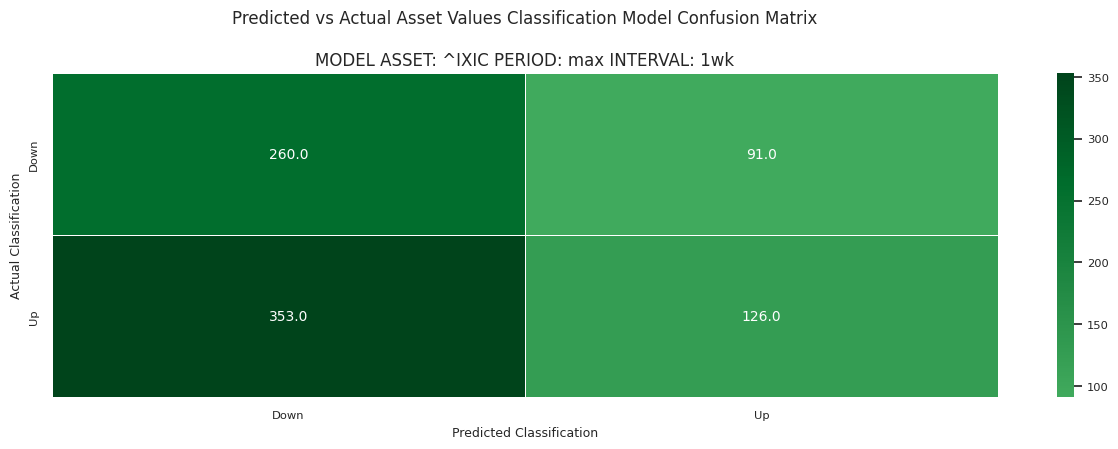

[*********************100%%**********************]  1 of 1 completed


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2008-03-03  2271.26  2290.01  2186.93  2212.49  11576210000  0             1          
2008-03-10  2211.14  2282.61  2168.67  2212.49  11670720000  1             1          
2008-03-17  2166.94  2280.90  2155.42  2258.11   9779740000  1             0          
2008-03-24  2268.20  2346.78  2256.87  2261.18  10151410000  1             0          
2008-03-31  2265.15  2391.93  2260.59  2370.98   9916200000  0             1          
2008-04-07  2386.62  2390.04  2286.19  2290.24   9348900000  1             1          
2008-04-14  2287.02  2412.78  2266.29  2402.97   9610450000  1             1          
2008-04-21  2393.07  2447.28  2361.67  2422.93  10017960000  1             1          
2008-04-28  2422.63  2499.14  2406.37  2476.99  10245380000  0  


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
 
              precision    recall  f1-score   support

           0       0.33      1.00      0.49        46
           1       1.00      0.00      0.00        95

    accuracy                           0.33       141
   macro avg       0.66      0.50      0.25       141
weighted avg       0.78      0.33      0.16       141

 



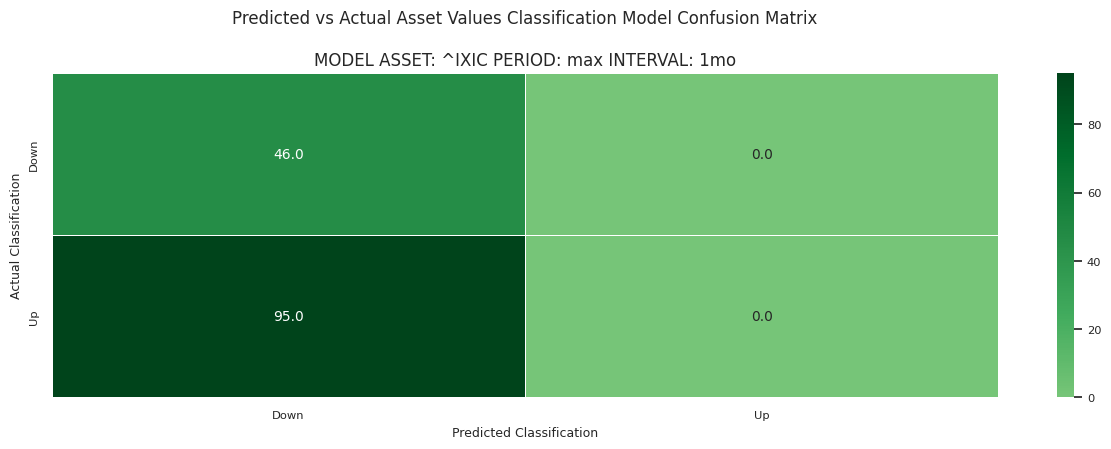


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2012-05-01  3044.79  3085.40  2774.45  2827.34  40115930000  1             0          
2012-06-01  2810.13  2942.28  2726.68  2935.05  37458650000  1             0          
2012-07-01  2938.41  2987.94  2837.72  2939.52  34686680000  1             0          
2012-08-01  2956.72  3100.54  2890.85  3066.96  35708950000  1             0          
2012-09-01  3063.25  3196.93  3040.24  3116.23  33719730000  0             0          
2012-10-01  3130.31  3171.46  2961.16  2977.23  36367020000  1             0          
2012-11-01  2987.54  3033.85  2810.80  3010.24  36894240000  1             0          
2012-12-01  3029.21  3061.82  2951.04  3019.51  33522490000  1             0          
2013-01-01  3091.33  3164.06  3076.60  3142.13  39027620000  1  

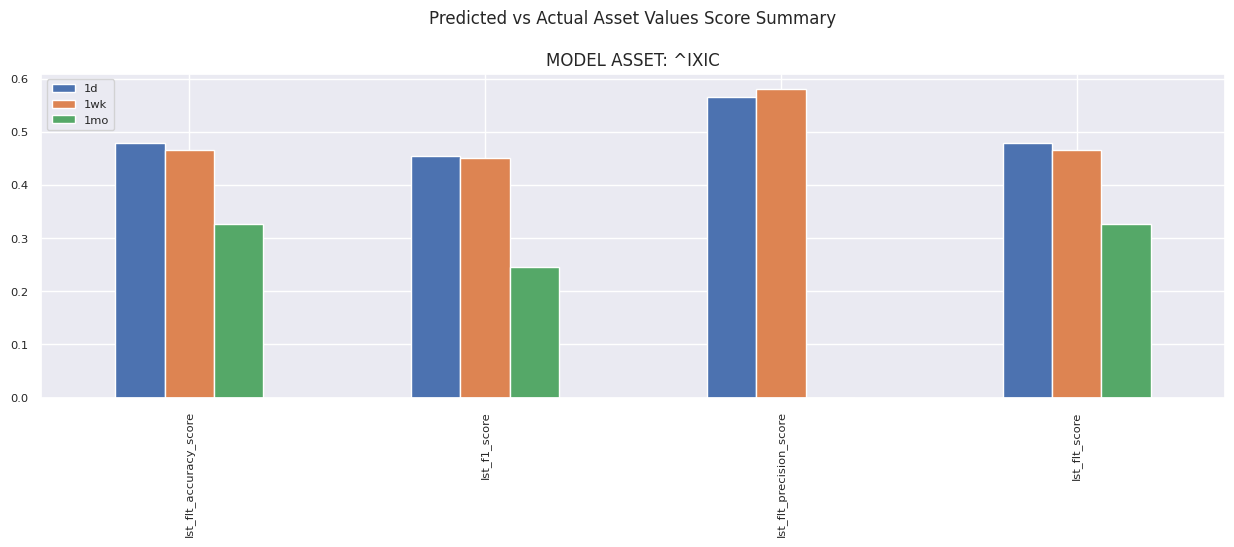

In [14]:
AssetData(str_co_ticker_1).run_class_model()

# Method run_class_model_list


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.44      0.76      0.56      1795
           1       0.54      0.23      0.32      2215

    accuracy                           0.47      4010
   macro avg       0.49      0.49      0.44      4010
weighted avg       0.50      0.47      0.43      4010

 



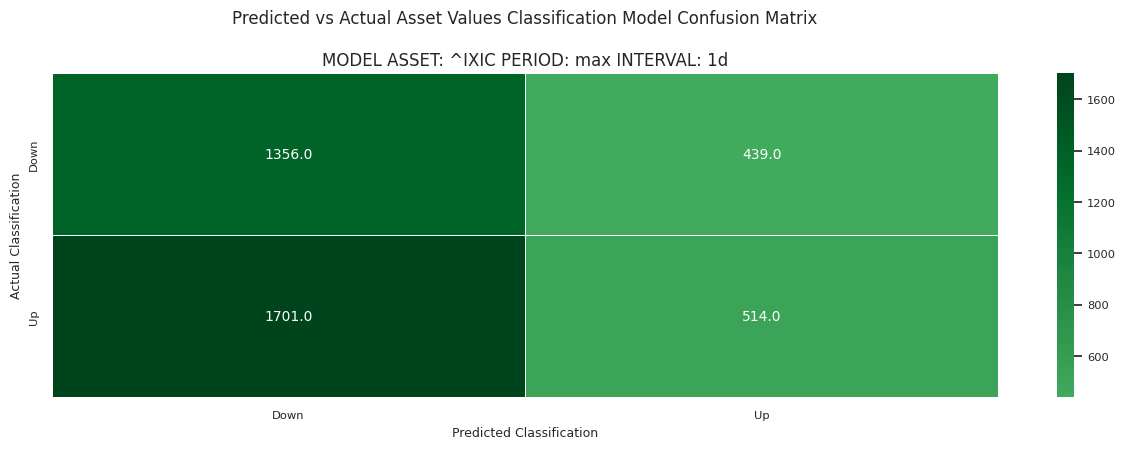


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume      target_class  target_pred
date                                                                                 
2008-02-29  2309.06  2311.23  2264.97  2271.48  2405360000  0             1          
2008-03-03  2271.26  2275.75  2240.30  2258.60  2145070000  1             1          
2008-03-04  2244.21  2266.37  2221.09  2260.28  2669980000  1             1          
2008-03-05  2266.49  2290.01  2254.20  2272.81  2209090000  0             1          
2008-03-06  2265.67  2272.20  2219.33  2220.50  2165090000  0             0          
2008-03-07  2204.48  2242.50  2186.93  2212.49  2386980000  0             0          
2008-03-10  2211.14  2216.89  2168.67  2169.34  2101010000  1             1          
2008-03-11  2209.65  2255.76  2192.50  2255.76  2526040000  0             1          
2008-03-12  2259.97  2282.61  2241.38  2243.87  2077140000  1             

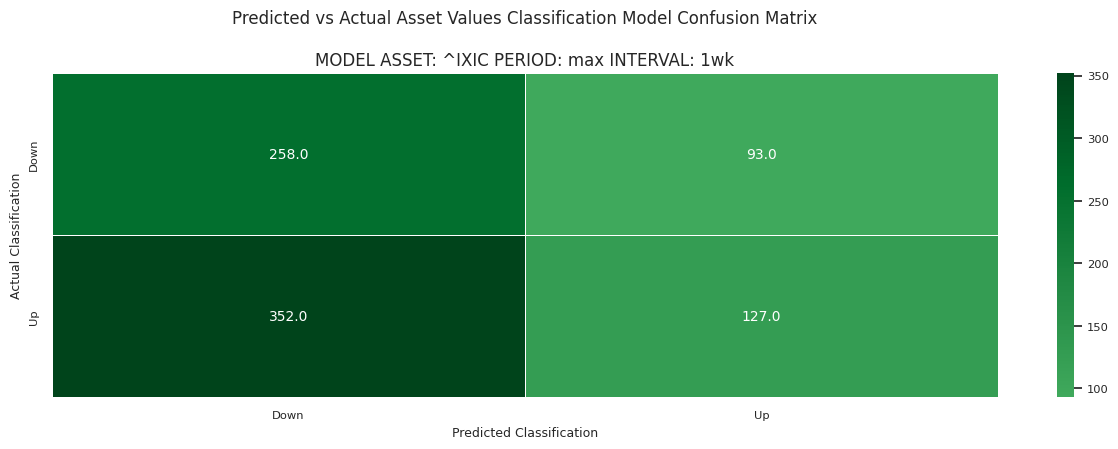


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2008-03-03  2271.26  2290.01  2186.93  2212.49  11576210000  0             1          
2008-03-10  2211.14  2282.61  2168.67  2212.49  11670720000  1             1          
2008-03-17  2166.94  2280.90  2155.42  2258.11   9779740000  1             0          
2008-03-24  2268.20  2346.78  2256.87  2261.18  10151410000  1             0          
2008-03-31  2265.15  2391.93  2260.59  2370.98   9916200000  0             1          
2008-04-07  2386.62  2390.04  2286.19  2290.24   9348900000  1             0          
2008-04-14  2287.02  2412.78  2266.29  2402.97   9610450000  1             1          
2008-04-21  2393.07  2447.28  2361.67  2422.93  10017960000  1             1          
2008-04-28  2422.63  2499.14  2406.37  2476.99  10245380000  0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
 
              precision    recall  f1-score   support

           0       0.33      1.00      0.49        46
           1       1.00      0.00      0.00        95

    accuracy                           0.33       141
   macro avg       0.66      0.50      0.25       141
weighted avg       0.78      0.33      0.16       141

 



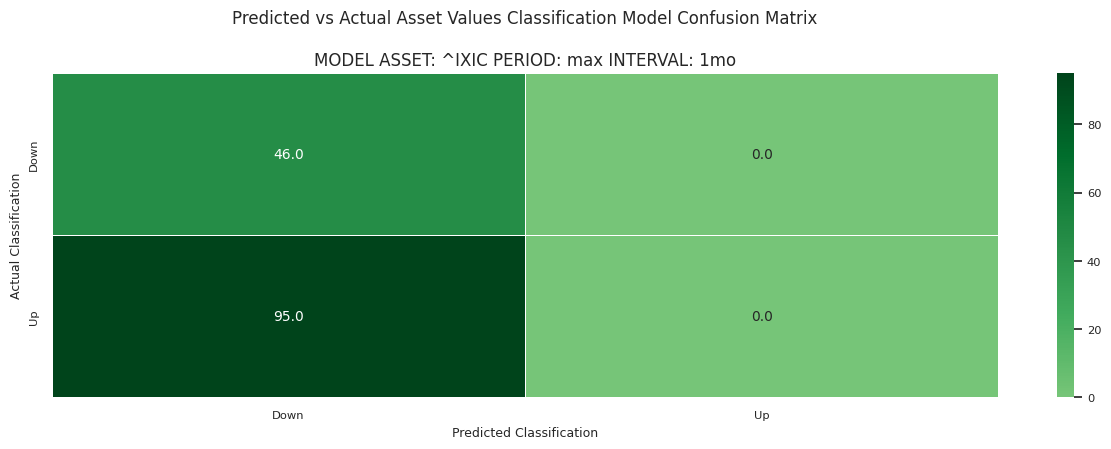


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2012-05-01  3044.79  3085.40  2774.45  2827.34  40115930000  1             0          
2012-06-01  2810.13  2942.28  2726.68  2935.05  37458650000  1             0          
2012-07-01  2938.41  2987.94  2837.72  2939.52  34686680000  1             0          
2012-08-01  2956.72  3100.54  2890.85  3066.96  35708950000  1             0          
2012-09-01  3063.25  3196.93  3040.24  3116.23  33719730000  0             0          
2012-10-01  3130.31  3171.46  2961.16  2977.23  36367020000  1             0          
2012-11-01  2987.54  3033.85  2810.80  3010.24  36894240000  1             0          
2012-12-01  3029.21  3061.82  2951.04  3019.51  33522490000  1             0          
2013-01-01  3091.33  3164.06  3076.60  3142.13  39027620000  1  

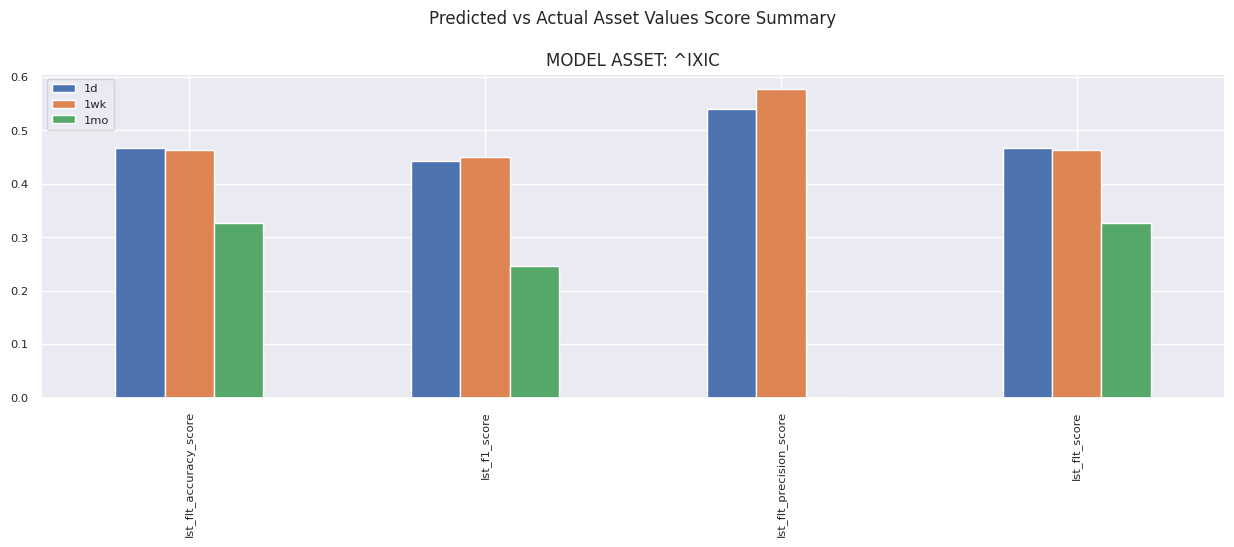


 

None

 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.49      0.82      0.61      2284
           1       0.52      0.19      0.27      2405

    accuracy                           0.49      4689
   macro avg       0.50      0.50      0.44      4689
weighted avg       0.50      0.49      0.44      4689

 



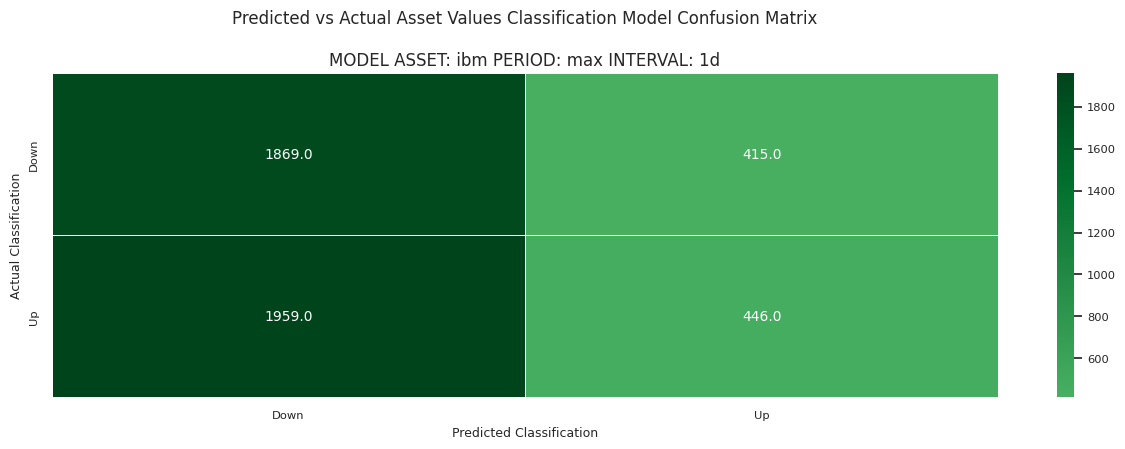


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open    high    low     close   volume    target_class  target_pred
date                                                                           
2005-06-17  74.283  74.312  73.021  73.031   8989115  1             1          
2005-06-20  72.686  73.595  72.247  73.184   3917898  0             0          
2005-06-21  73.327  73.614  72.763  73.050   5584699  1             0          
2005-06-22  73.451  74.082  73.298  73.834   5906030  0             0          
2005-06-23  73.432  73.585  71.759  72.094   8123968  0             0          
2005-06-24  71.864  72.084  70.746  70.755  11288537  0             1          
2005-06-27  70.755  71.482  70.268  70.631   6788331  1             1          
2005-06-28  70.583  71.989  70.220  71.989   8565485  0             1          
2005-06-29  71.950  72.352  71.338  71.444   5772979  0             0          
2005-06-30  71.511  72.170  70.813  70.937   6408842  

[*********************100%%**********************]  1 of 1 completed


Classification Report:
 
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       464
           1       0.63      0.19      0.29       508

    accuracy                           0.52       972
   macro avg       0.56      0.53      0.46       972
weighted avg       0.57      0.52      0.46       972

 



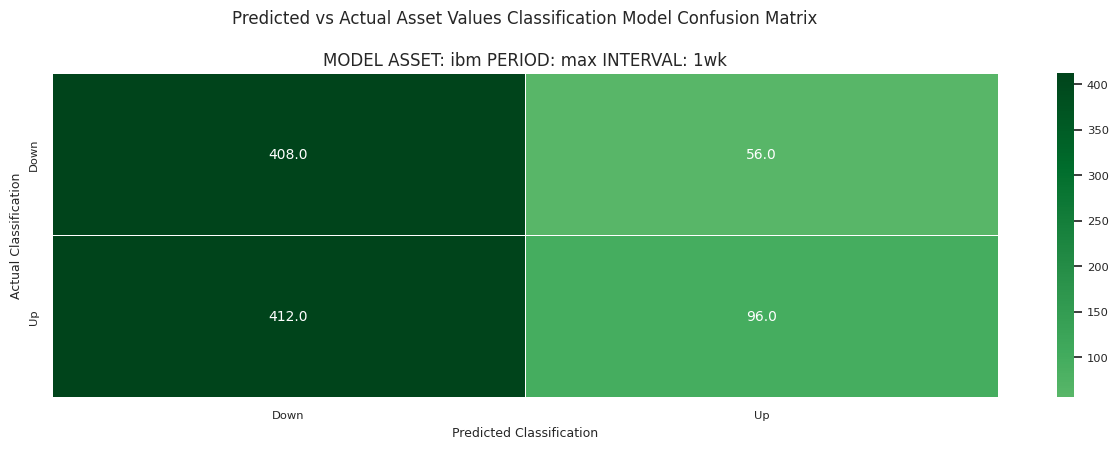


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open    high    low     close   volume    target_class  target_pred
date                                                                           
2005-06-13  71.224  74.312  71.176  73.031  35112128  0             1          
2005-06-20  72.686  74.082  70.746  70.755  34821132  1             1          
2005-06-27  70.755  72.352  70.220  71.386  32088980  1             1          
2005-07-04  71.109  76.023  70.899  75.813  39108685  1             1          
2005-07-11  75.908  79.111  75.067  78.757  47762975  1             0          
2005-07-18  78.384  81.367  78.088  80.727  47084853  0             1          
2005-07-25  80.287  80.803  79.168  79.790  25504513  0             1          
2005-08-01  79.350  80.497  79.092  79.694  23289922  0             1          
2005-08-08  79.742  80.315  78.031  78.576  23606964  1             1          
2005-08-15  78.298  79.637  77.247  79.120  23938547  

[*********************100%%**********************]  1 of 1 completed


Classification Report:
 
              precision    recall  f1-score   support

           0       0.48      0.89      0.62       105
           1       0.61      0.16      0.25       119

    accuracy                           0.50       224
   macro avg       0.55      0.52      0.44       224
weighted avg       0.55      0.50      0.43       224

 



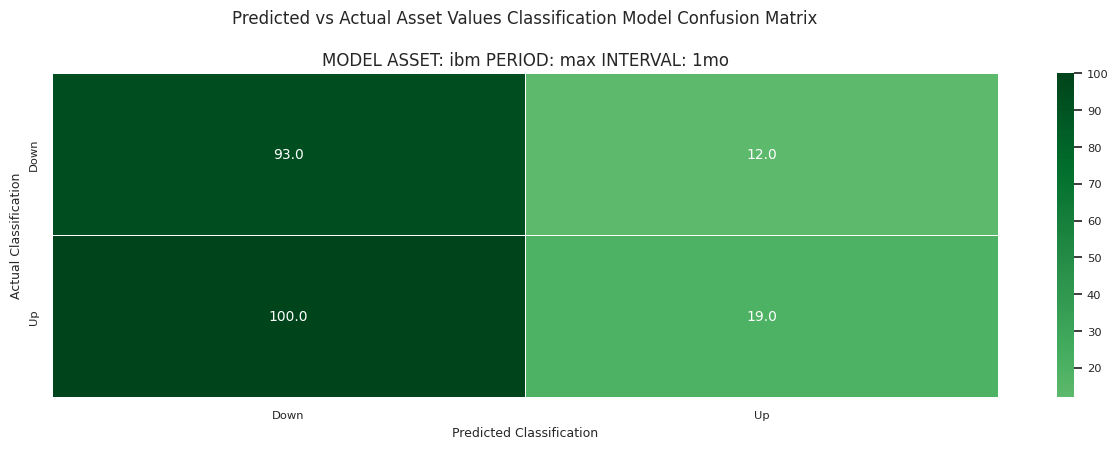


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open    high    low     close   volume     target_class  target_pred
date                                                                            
2005-06-01  72.247  74.312  70.220  70.937  141777772  1             1          
2005-07-01  71.033  81.367  70.899  79.790  164014369  0             1          
2005-08-01  79.350  80.497  76.358  77.075  109862531  0             1          
2005-09-01  76.635  78.499  73.547  76.692  121002745  1             1          
2005-10-01  76.692  80.880  75.239  78.279  146316365  1             1          
2005-11-01  78.250  85.985  77.094  84.990  115755068  0             1          
2005-12-01  85.229  85.966  77.973  78.585  125574811  0             1          
2006-01-01  78.824  81.291  76.683  77.725  153230215  0             1          
2006-02-01  77.342  78.623  75.459  76.711  116160600  1             1          
2006-03-01  76.673  81.252  76.013  78.843 

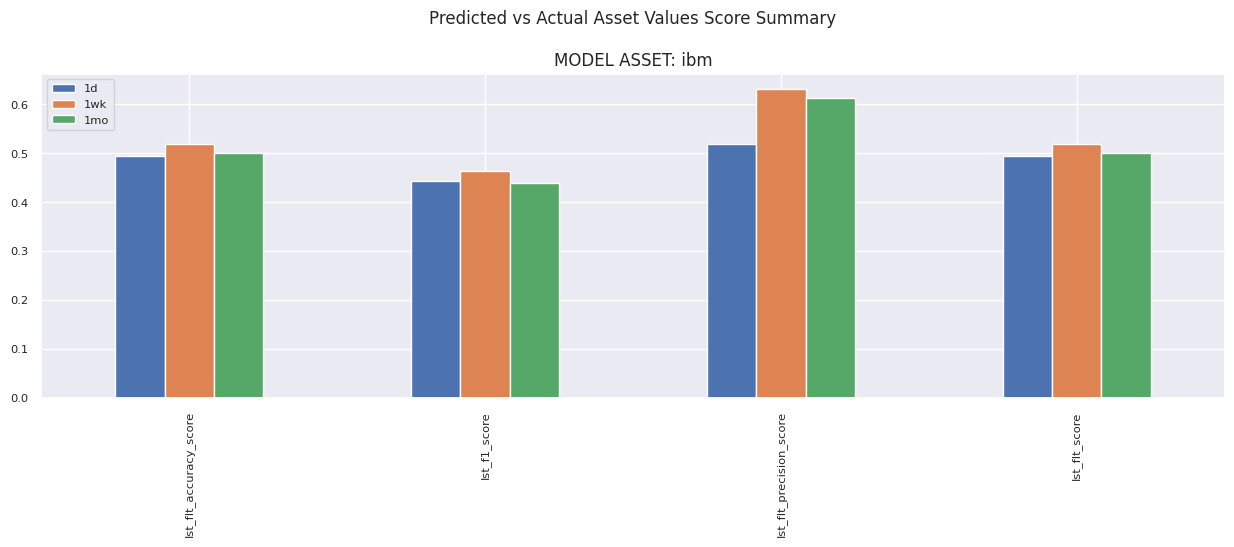


 

None

 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           0       0.45      0.76      0.56      1795
           1       0.55      0.23      0.33      2215

    accuracy                           0.47      4010
   macro avg       0.50      0.50      0.45      4010
weighted avg       0.50      0.47      0.43      4010

 



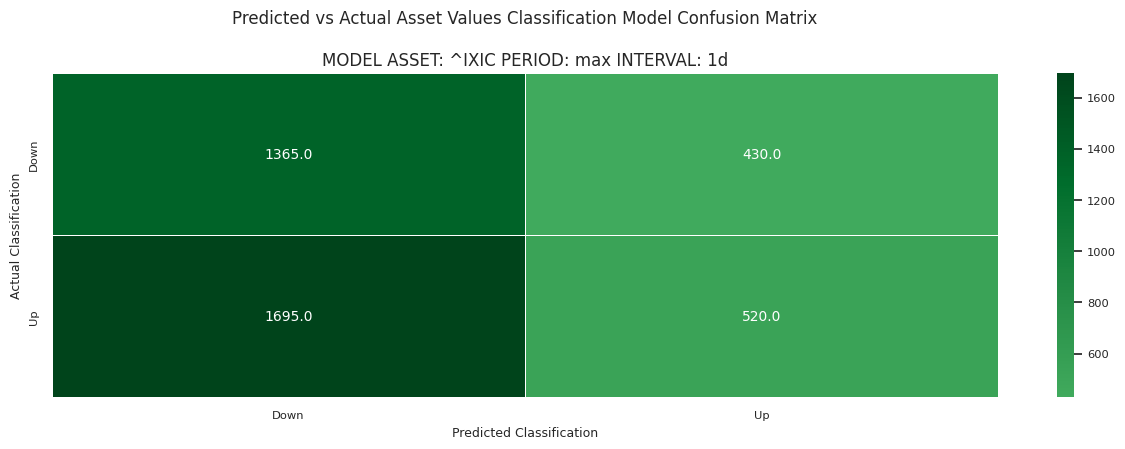


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume      target_class  target_pred
date                                                                                 
2008-02-29  2309.06  2311.23  2264.97  2271.48  2405360000  0             1          
2008-03-03  2271.26  2275.75  2240.30  2258.60  2145070000  1             1          
2008-03-04  2244.21  2266.37  2221.09  2260.28  2669980000  1             1          
2008-03-05  2266.49  2290.01  2254.20  2272.81  2209090000  0             1          
2008-03-06  2265.67  2272.20  2219.33  2220.50  2165090000  0             0          
2008-03-07  2204.48  2242.50  2186.93  2212.49  2386980000  0             1          
2008-03-10  2211.14  2216.89  2168.67  2169.34  2101010000  1             0          
2008-03-11  2209.65  2255.76  2192.50  2255.76  2526040000  0             1          
2008-03-12  2259.97  2282.61  2241.38  2243.87  2077140000  1             

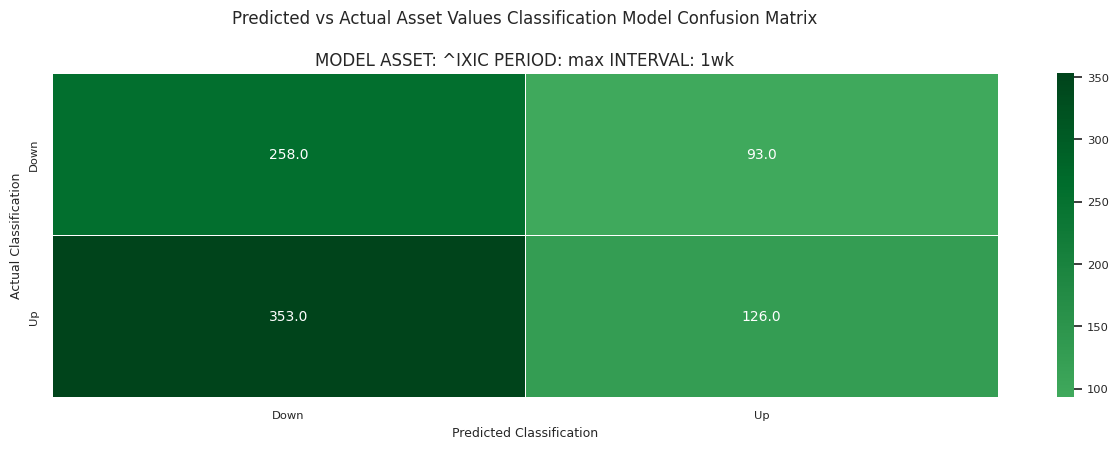


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2008-03-03  2271.26  2290.01  2186.93  2212.49  11576210000  0             1          
2008-03-10  2211.14  2282.61  2168.67  2212.49  11670720000  1             1          
2008-03-17  2166.94  2280.90  2155.42  2258.11   9779740000  1             0          
2008-03-24  2268.20  2346.78  2256.87  2261.18  10151410000  1             0          
2008-03-31  2265.15  2391.93  2260.59  2370.98   9916200000  0             1          
2008-04-07  2386.62  2390.04  2286.19  2290.24   9348900000  1             1          
2008-04-14  2287.02  2412.78  2266.29  2402.97   9610450000  1             0          
2008-04-21  2393.07  2447.28  2361.67  2422.93  10017960000  1             1          
2008-04-28  2422.63  2499.14  2406.37  2476.99  10245380000  0  

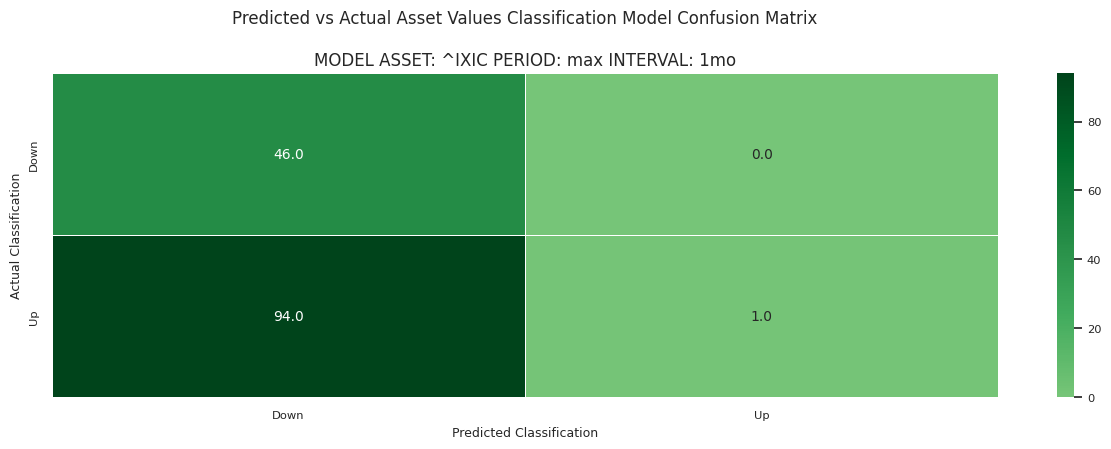


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2012-05-01  3044.79  3085.40  2774.45  2827.34  40115930000  1             0          
2012-06-01  2810.13  2942.28  2726.68  2935.05  37458650000  1             0          
2012-07-01  2938.41  2987.94  2837.72  2939.52  34686680000  1             1          
2012-08-01  2956.72  3100.54  2890.85  3066.96  35708950000  1             0          
2012-09-01  3063.25  3196.93  3040.24  3116.23  33719730000  0             0          
2012-10-01  3130.31  3171.46  2961.16  2977.23  36367020000  1             0          
2012-11-01  2987.54  3033.85  2810.80  3010.24  36894240000  1             0          
2012-12-01  3029.21  3061.82  2951.04  3019.51  33522490000  1             0          
2013-01-01  3091.33  3164.06  3076.60  3142.13  39027620000  1  

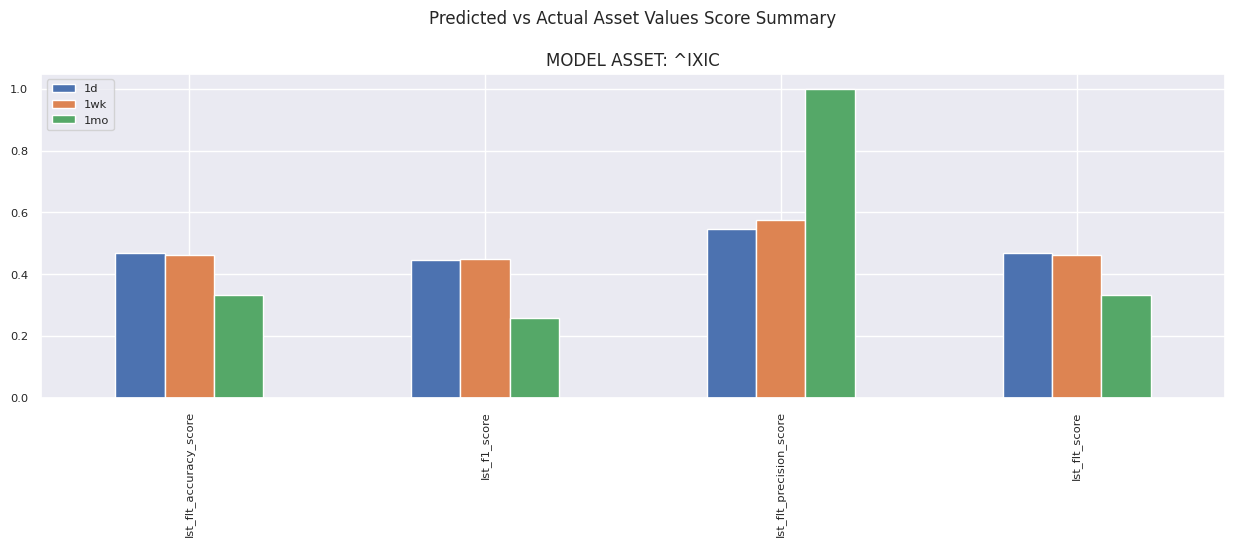


 

None


In [15]:
AssetData(str_co_ticker_1).run_class_model_list([str_co_ticker_1, str_co_ticker_2])

# Method run_mlr_model


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.22955581e-01  1.20082395e-01  6.45570124e-02  9.37518355e-01
  1.10382259e-10]
 

Model Intercept: 
 
0.6048044317642507
 



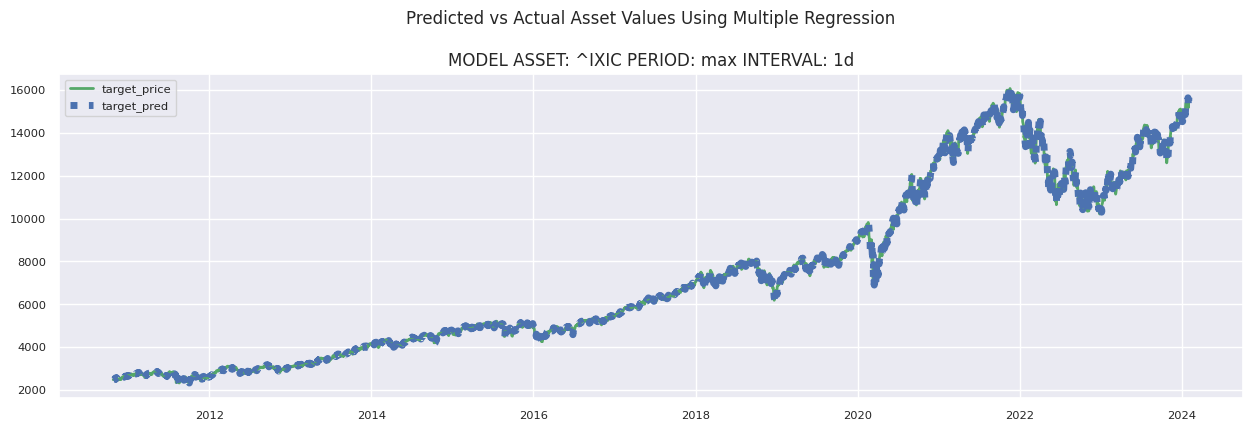


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume      target_price  target_pred
date                                                                                 
2010-10-25  2491.62  2507.03  2490.11  2490.85  1746320000  2497.29       2491.461   
2010-10-26  2476.51  2503.03  2470.12  2497.29  1914350000  2503.26       2497.604   
2010-10-27  2484.09  2505.35  2478.01  2503.26  2013240000  2507.37       2503.068   
2010-10-28  2516.16  2516.20  2489.76  2507.37  1998340000  2507.41       2505.038   
2010-10-29  2505.99  2517.50  2505.86  2507.41  2068700000  2504.84       2507.529   
2010-11-01  2520.45  2532.37  2491.46  2504.84  1904790000  2533.52       2504.180   
2010-11-02  2525.94  2534.88  2518.29  2533.52  1914980000  2540.27       2532.427   
2010-11-03  2532.83  2541.42  2511.31  2540.27  1990410000  2577.34       2538.251   
2010-11-04  2569.27  2579.62  2564.05  2577.34  2492050000  2578.98       

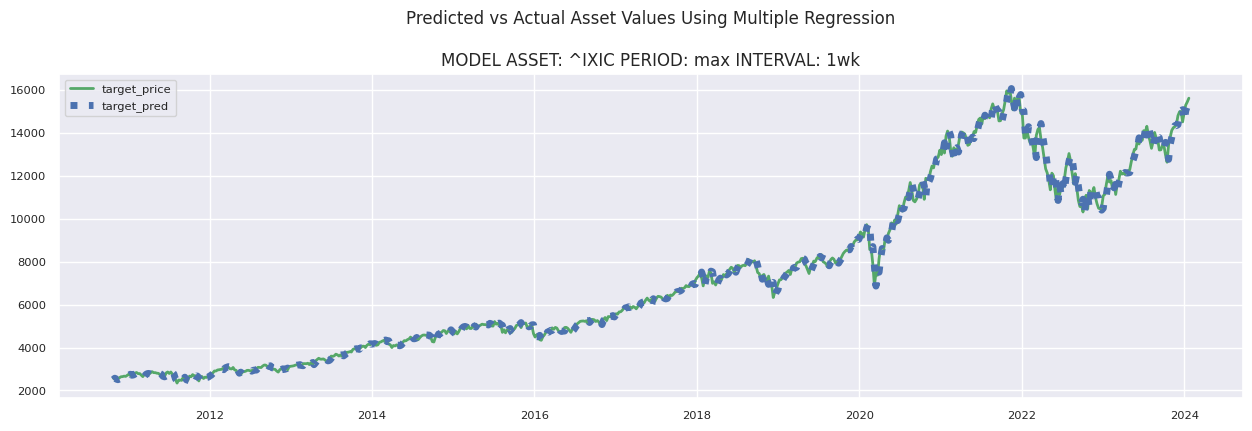


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2010-10-25  2491.62  2517.50  2470.12  2507.41   9740950000  2578.98       2504.836   
2010-11-01  2520.45  2582.18  2491.46  2578.98  10395080000  2518.21       2567.700   
2010-11-08  2570.86  2592.94  2506.40  2518.21  10707400000  2518.12       2530.033   
2010-11-15  2529.02  2534.56  2459.79  2518.12   9788890000  2534.56       2499.418   
2010-11-22  2509.39  2545.41  2483.16  2534.56   6001450000  2591.46       2533.772   
2010-11-29  2522.24  2593.68  2488.61  2591.46   9959210000  2637.54       2577.750   
2010-12-06  2591.28  2639.41  2584.09  2637.54   8948490000  2642.97       2637.192   
2010-12-13  2645.35  2651.35  2613.15  2642.97   9709700000  2665.60       2636.506   
2010-12-20  2651.98  2675.26  2634.56  2665.60   6239830000  265

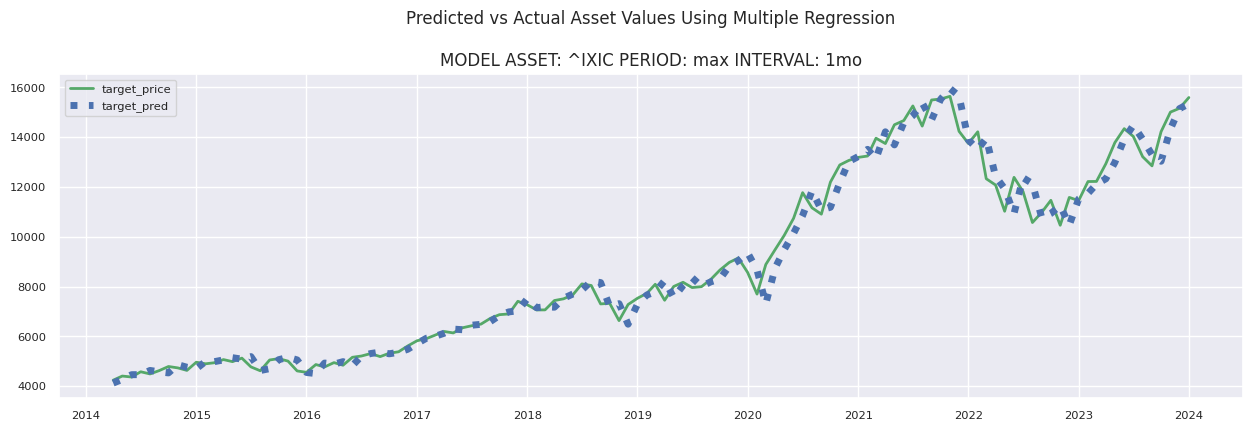


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2014-04-01  4219.87  4286.09  3946.03  4114.56  44391220000  4242.62       4125.977   
2014-05-01  4121.25  4252.08  4021.05  4242.62  39290130000  4408.18       4273.273   
2014-06-01  4247.96  4417.46  4207.61  4408.18  40249370000  4369.77       4462.887   
2014-07-01  4424.71  4485.93  4351.04  4369.77  39536410000  4580.27       4465.870   
2014-08-01  4363.39  4580.27  4321.89  4580.27  33417300000  4493.39       4632.921   
2014-09-01  4592.42  4610.57  4464.44  4493.39  39631130000  4630.74       4576.200   
2014-10-01  4486.65  4641.51  4116.60  4630.74  50136190000  4791.63       4535.192   
2014-11-01  4633.71  4810.86  4594.92  4791.63  32967990000  4736.05       4865.765   
2014-12-01  4777.73  4814.95  4547.31  4736.05  39587090000  463

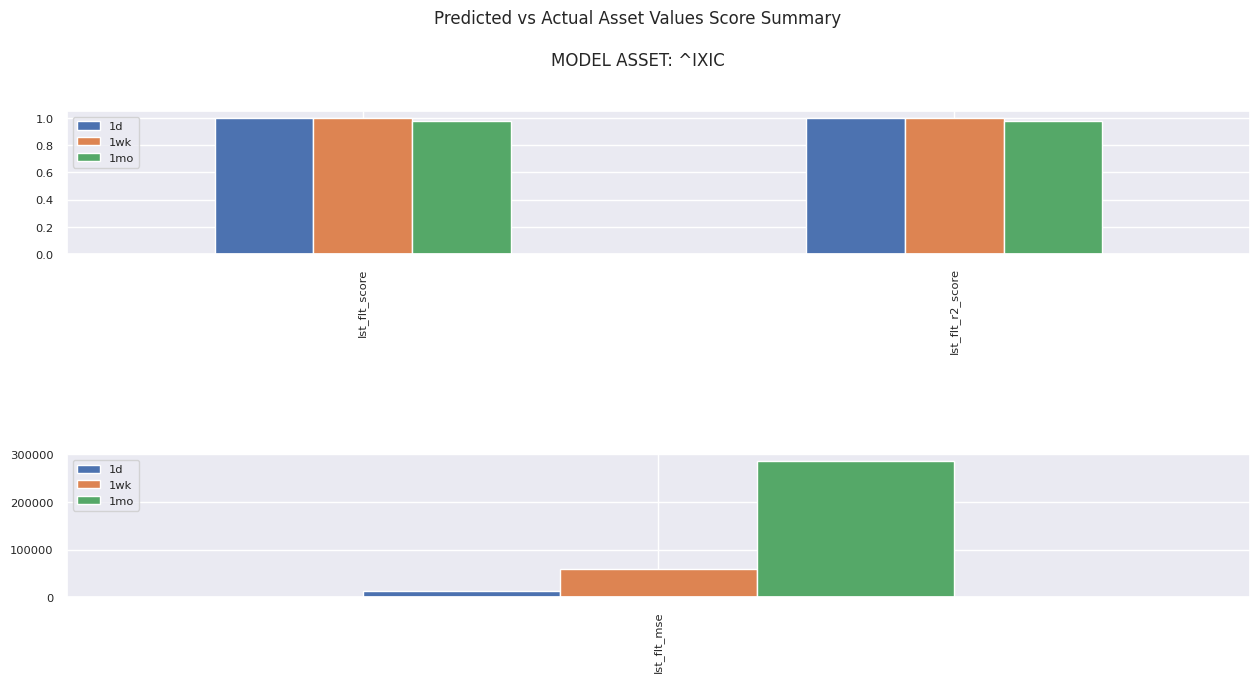

In [19]:
AssetData(str_co_ticker_1).run_mlr_model()

# Method run_mlr_model_list


 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.22955581e-01  1.20082395e-01  6.45570124e-02  9.37518355e-01
  1.10382259e-10]
 

Model Intercept: 
 
0.6048044317642507
 



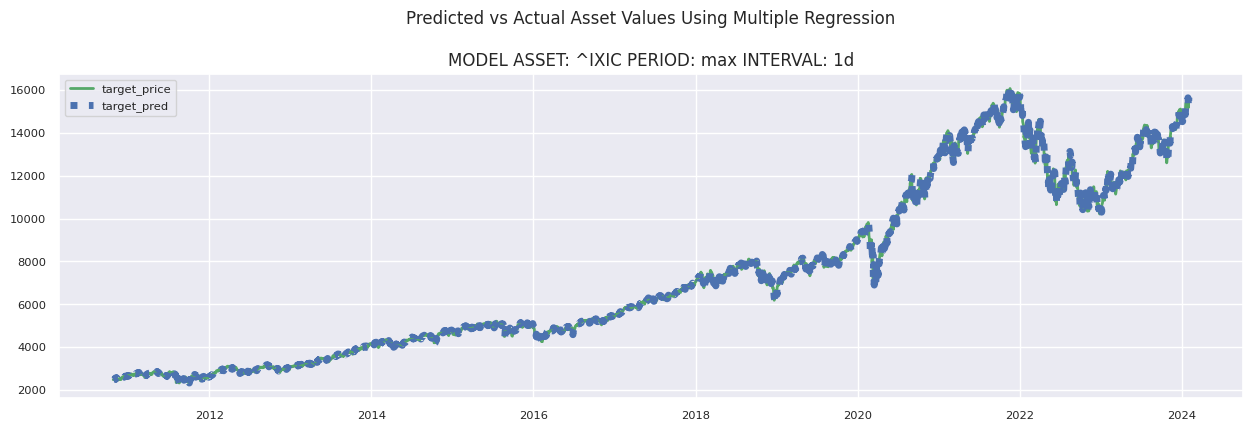


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume      target_price  target_pred
date                                                                                 
2010-10-25  2491.62  2507.03  2490.11  2490.85  1746320000  2497.29       2491.461   
2010-10-26  2476.51  2503.03  2470.12  2497.29  1914350000  2503.26       2497.604   
2010-10-27  2484.09  2505.35  2478.01  2503.26  2013240000  2507.37       2503.068   
2010-10-28  2516.16  2516.20  2489.76  2507.37  1998340000  2507.41       2505.038   
2010-10-29  2505.99  2517.50  2505.86  2507.41  2068700000  2504.84       2507.529   
2010-11-01  2520.45  2532.37  2491.46  2504.84  1904790000  2533.52       2504.180   
2010-11-02  2525.94  2534.88  2518.29  2533.52  1914980000  2540.27       2532.427   
2010-11-03  2532.83  2541.42  2511.31  2540.27  1990410000  2577.34       2538.251   
2010-11-04  2569.27  2579.62  2564.05  2577.34  2492050000  2578.98       

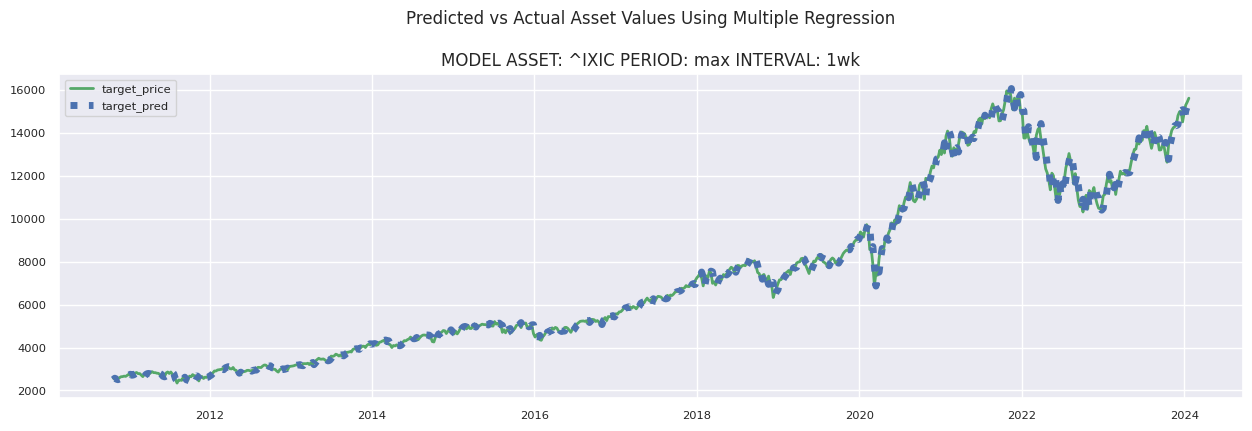


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2010-10-25  2491.62  2517.50  2470.12  2507.41   9740950000  2578.98       2504.836   
2010-11-01  2520.45  2582.18  2491.46  2578.98  10395080000  2518.21       2567.700   
2010-11-08  2570.86  2592.94  2506.40  2518.21  10707400000  2518.12       2530.033   
2010-11-15  2529.02  2534.56  2459.79  2518.12   9788890000  2534.56       2499.418   
2010-11-22  2509.39  2545.41  2483.16  2534.56   6001450000  2591.46       2533.772   
2010-11-29  2522.24  2593.68  2488.61  2591.46   9959210000  2637.54       2577.750   
2010-12-06  2591.28  2639.41  2584.09  2637.54   8948490000  2642.97       2637.192   
2010-12-13  2645.35  2651.35  2613.15  2642.97   9709700000  2665.60       2636.506   
2010-12-20  2651.98  2675.26  2634.56  2665.60   6239830000  265

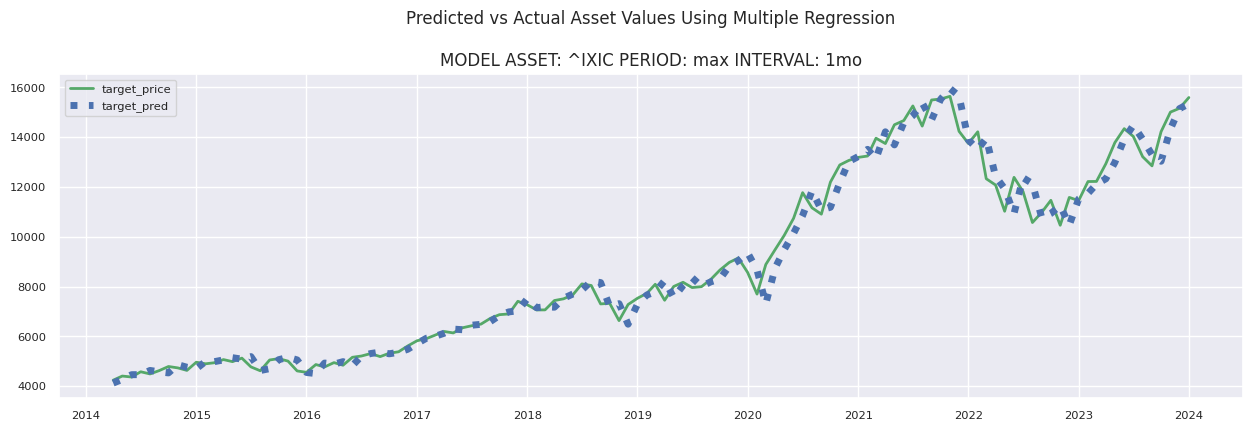


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2014-04-01  4219.87  4286.09  3946.03  4114.56  44391220000  4242.62       4125.977   
2014-05-01  4121.25  4252.08  4021.05  4242.62  39290130000  4408.18       4273.273   
2014-06-01  4247.96  4417.46  4207.61  4408.18  40249370000  4369.77       4462.887   
2014-07-01  4424.71  4485.93  4351.04  4369.77  39536410000  4580.27       4465.870   
2014-08-01  4363.39  4580.27  4321.89  4580.27  33417300000  4493.39       4632.921   
2014-09-01  4592.42  4610.57  4464.44  4493.39  39631130000  4630.74       4576.200   
2014-10-01  4486.65  4641.51  4116.60  4630.74  50136190000  4791.63       4535.192   
2014-11-01  4633.71  4810.86  4594.92  4791.63  32967990000  4736.05       4865.765   
2014-12-01  4777.73  4814.95  4547.31  4736.05  39587090000  463

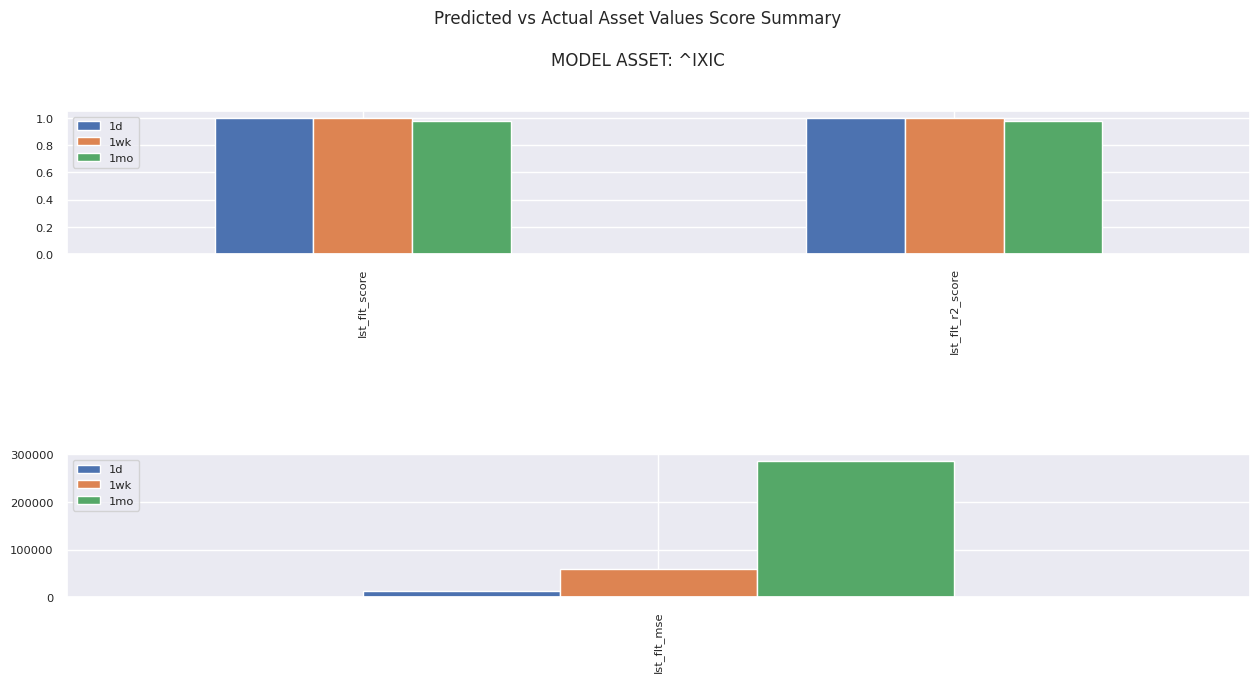


 

None

 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.59277813e-01  2.92980091e-01  1.58738821e-01  7.05577139e-01
  2.73126693e-09]
 

Model Intercept: 
 
0.014231446998714148
 



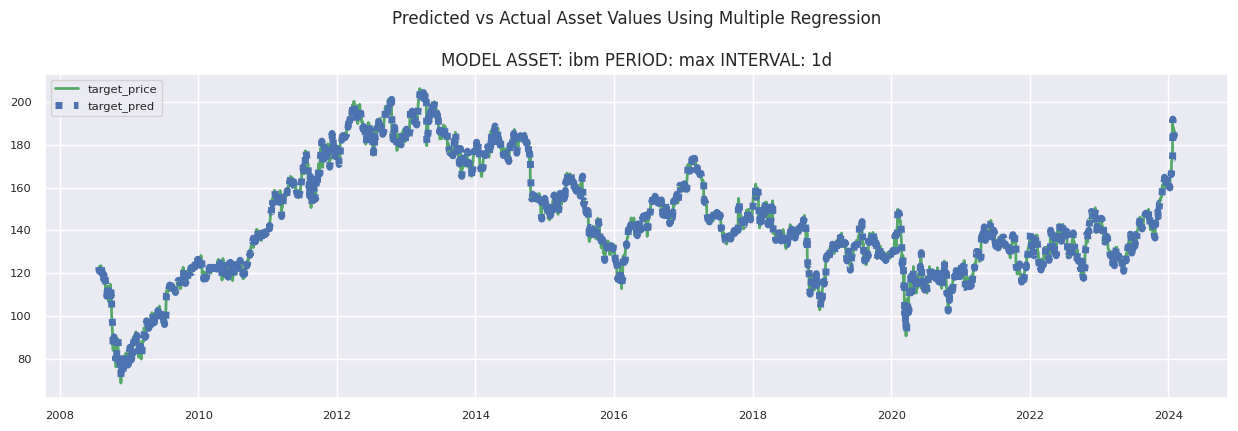


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume   target_price  target_pred
date                                                                              
2008-07-25  123.327  124.187  122.371  122.878  7913513  120.698       122.902    
2008-07-28  122.075  122.792  120.583  120.698  6377253  122.046       120.866    
2008-07-29  120.975  122.533  120.698  122.046  6254452  123.193       121.935    
2008-07-30  122.486  123.327  121.501  123.193  6094101  122.352       122.863    
2008-07-31  122.467  123.805  122.122  122.352  6126736  121.071       122.511    
2008-08-01  122.868  123.614  120.727  121.071  5166926  121.950       121.263    
2008-08-04  121.195  122.467  120.698  121.950  6270665  123.203       121.813    
2008-08-05  122.562  123.231  121.491  123.203  7290515  123.480       122.831    
2008-08-06  122.801  123.805  122.132  123.480  6541475  123.375       123.257    
2008-08-07  122.658  

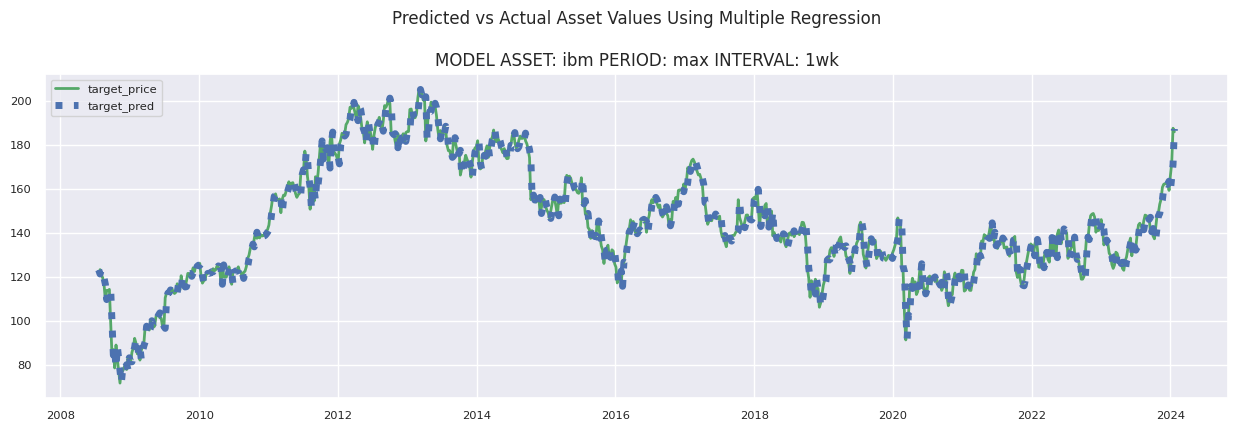


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume    target_price  target_pred
date                                                                               
2008-07-21  124.120  125.172  121.663  122.878  48064015  121.071       122.990    
2008-07-28  122.075  123.805  120.583  121.071  30019468  123.145       121.163    
2008-08-04  121.195  124.254  120.698  123.145  35996939  120.803       123.107    
2008-08-11  122.782  122.782  118.929  120.803  34229513  119.436       120.731    
2008-08-18  120.927  121.415  116.205  119.436  36042441  116.377       119.267    
2008-08-25  119.006  119.933  116.157  116.377  31896305  109.302       116.500    
2008-09-01  117.467  118.547  108.193  109.302  43944134  113.738       109.533    
2008-09-08  112.811  114.675  109.943  113.738  48935855  113.623       113.630    
2008-09-15  110.287  118.547  105.746  113.623  69357227  114.168       113.538    
2008-09-22

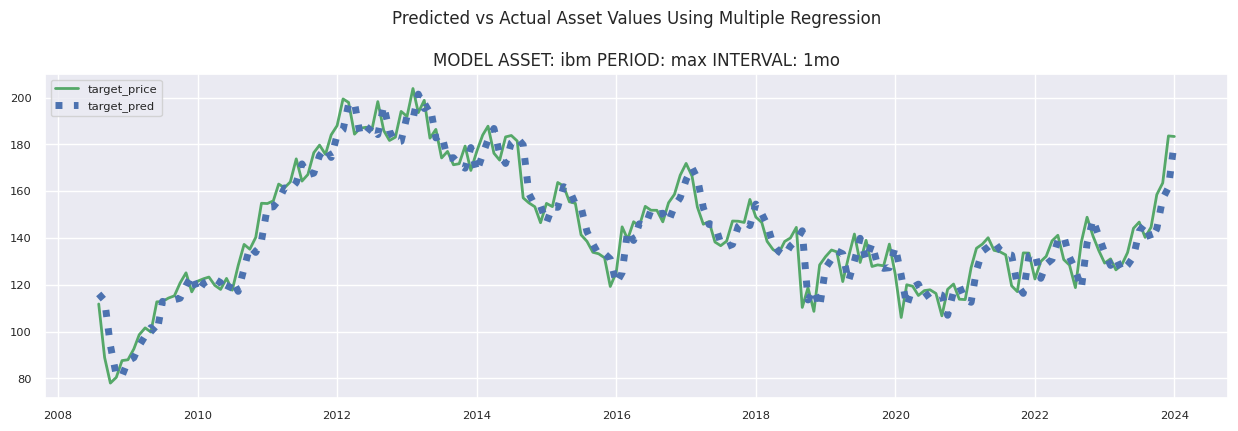


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume     target_price  target_pred
date                                                                                
2008-08-01  122.868  124.254  116.157  116.377  143332124  111.816       116.115    
2008-09-01  117.467  118.547  105.115  111.816  228458639   88.881       113.257    
2008-10-01  110.430  111.663   75.354   88.881  329460712   78.011        94.134    
2008-11-01   88.566   90.593   66.444   78.011  228355399   80.459        81.297    
2008-12-01   77.390   83.432   71.998   80.459  197533020   87.619        81.065    
2009-01-01   80.201   90.765   78.164   87.619  218571533   87.983        87.485    
2009-02-01   86.616   92.830   79.206   87.983  233276408   92.629        88.879    
2009-03-01   87.161   95.468   79.369   92.629  299275766   98.671        94.014    
2009-04-01   91.902  101.386   91.491   98.671  223449759  101.606        98.138    

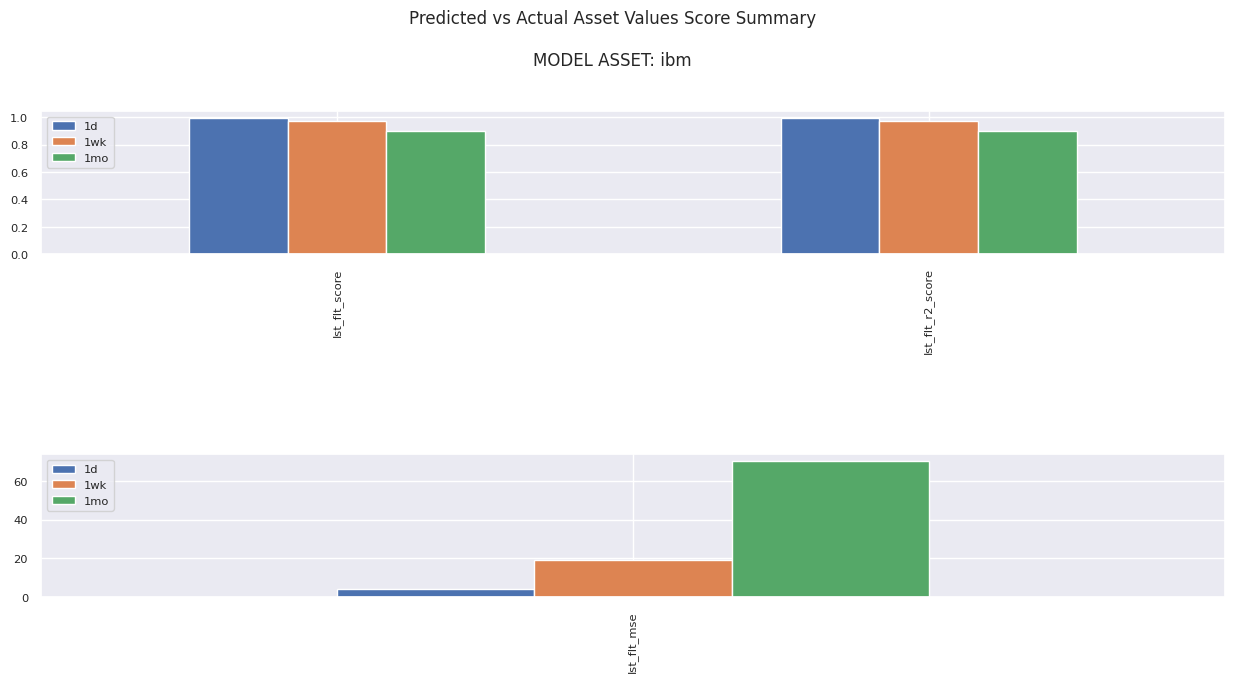


 

None

 
MODEL ASSET: ^IXIC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^IXIC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.22955581e-01  1.20082395e-01  6.45570124e-02  9.37518355e-01
  1.10382259e-10]
 

Model Intercept: 
 
0.6048044317642507
 



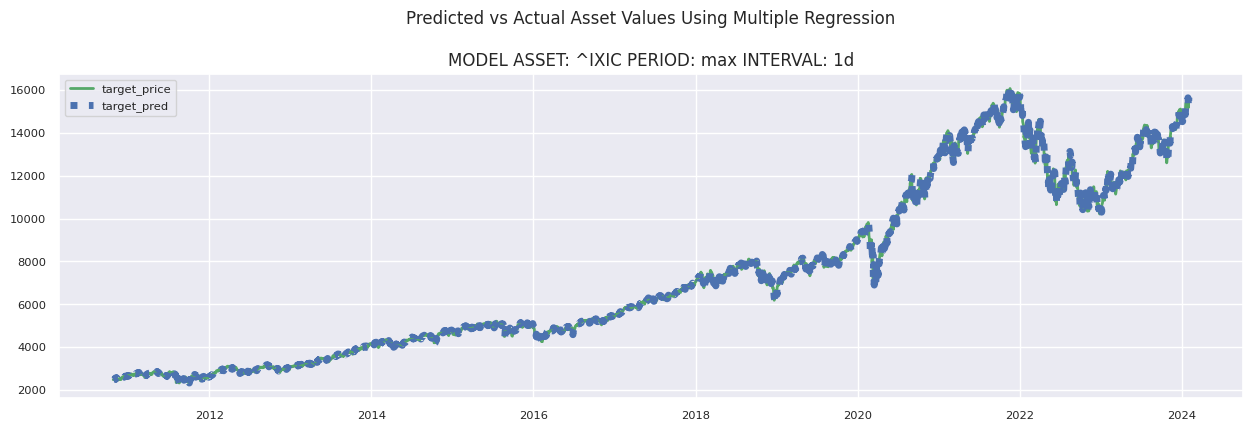


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume      target_price  target_pred
date                                                                                 
2010-10-25  2491.62  2507.03  2490.11  2490.85  1746320000  2497.29       2491.461   
2010-10-26  2476.51  2503.03  2470.12  2497.29  1914350000  2503.26       2497.604   
2010-10-27  2484.09  2505.35  2478.01  2503.26  2013240000  2507.37       2503.068   
2010-10-28  2516.16  2516.20  2489.76  2507.37  1998340000  2507.41       2505.038   
2010-10-29  2505.99  2517.50  2505.86  2507.41  2068700000  2504.84       2507.529   
2010-11-01  2520.45  2532.37  2491.46  2504.84  1904790000  2533.52       2504.180   
2010-11-02  2525.94  2534.88  2518.29  2533.52  1914980000  2540.27       2532.427   
2010-11-03  2532.83  2541.42  2511.31  2540.27  1990410000  2577.34       2538.251   
2010-11-04  2569.27  2579.62  2564.05  2577.34  2492050000  2578.98       

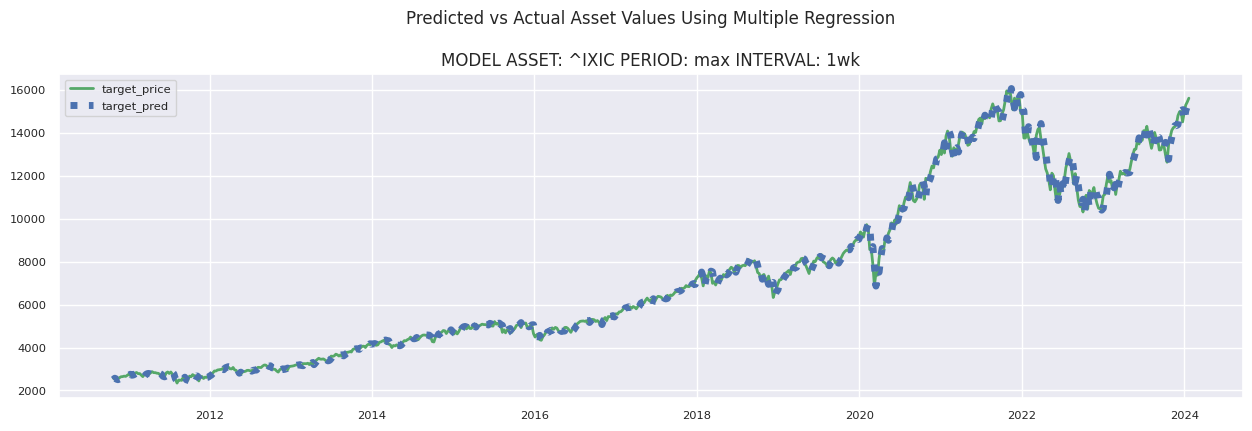


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2010-10-25  2491.62  2517.50  2470.12  2507.41   9740950000  2578.98       2504.836   
2010-11-01  2520.45  2582.18  2491.46  2578.98  10395080000  2518.21       2567.700   
2010-11-08  2570.86  2592.94  2506.40  2518.21  10707400000  2518.12       2530.033   
2010-11-15  2529.02  2534.56  2459.79  2518.12   9788890000  2534.56       2499.418   
2010-11-22  2509.39  2545.41  2483.16  2534.56   6001450000  2591.46       2533.772   
2010-11-29  2522.24  2593.68  2488.61  2591.46   9959210000  2637.54       2577.750   
2010-12-06  2591.28  2639.41  2584.09  2637.54   8948490000  2642.97       2637.192   
2010-12-13  2645.35  2651.35  2613.15  2642.97   9709700000  2665.60       2636.506   
2010-12-20  2651.98  2675.26  2634.56  2665.60   6239830000  265

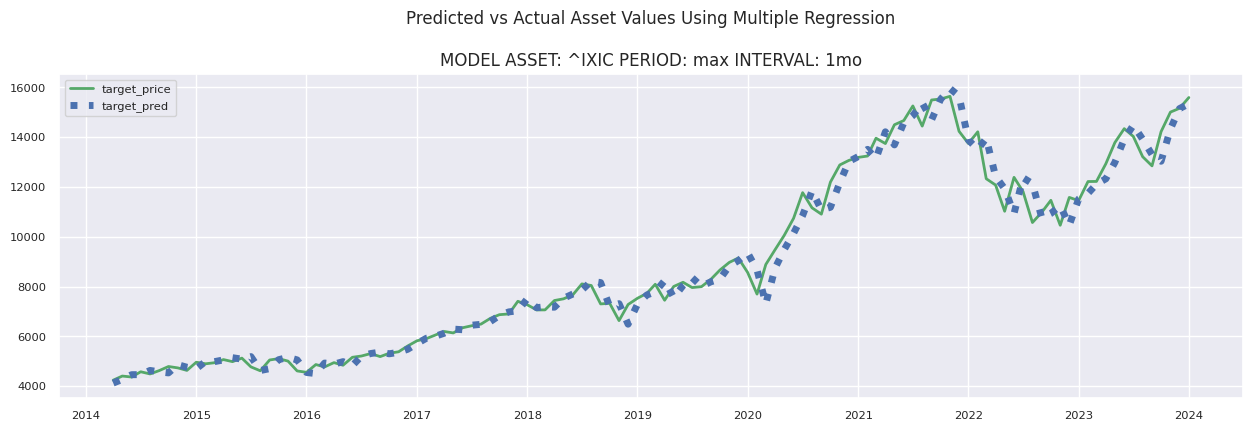


 

Feature, Target and Prediction Comparison: First 20 Records
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2014-04-01  4219.87  4286.09  3946.03  4114.56  44391220000  4242.62       4125.977   
2014-05-01  4121.25  4252.08  4021.05  4242.62  39290130000  4408.18       4273.273   
2014-06-01  4247.96  4417.46  4207.61  4408.18  40249370000  4369.77       4462.887   
2014-07-01  4424.71  4485.93  4351.04  4369.77  39536410000  4580.27       4465.870   
2014-08-01  4363.39  4580.27  4321.89  4580.27  33417300000  4493.39       4632.921   
2014-09-01  4592.42  4610.57  4464.44  4493.39  39631130000  4630.74       4576.200   
2014-10-01  4486.65  4641.51  4116.60  4630.74  50136190000  4791.63       4535.192   
2014-11-01  4633.71  4810.86  4594.92  4791.63  32967990000  4736.05       4865.765   
2014-12-01  4777.73  4814.95  4547.31  4736.05  39587090000  463

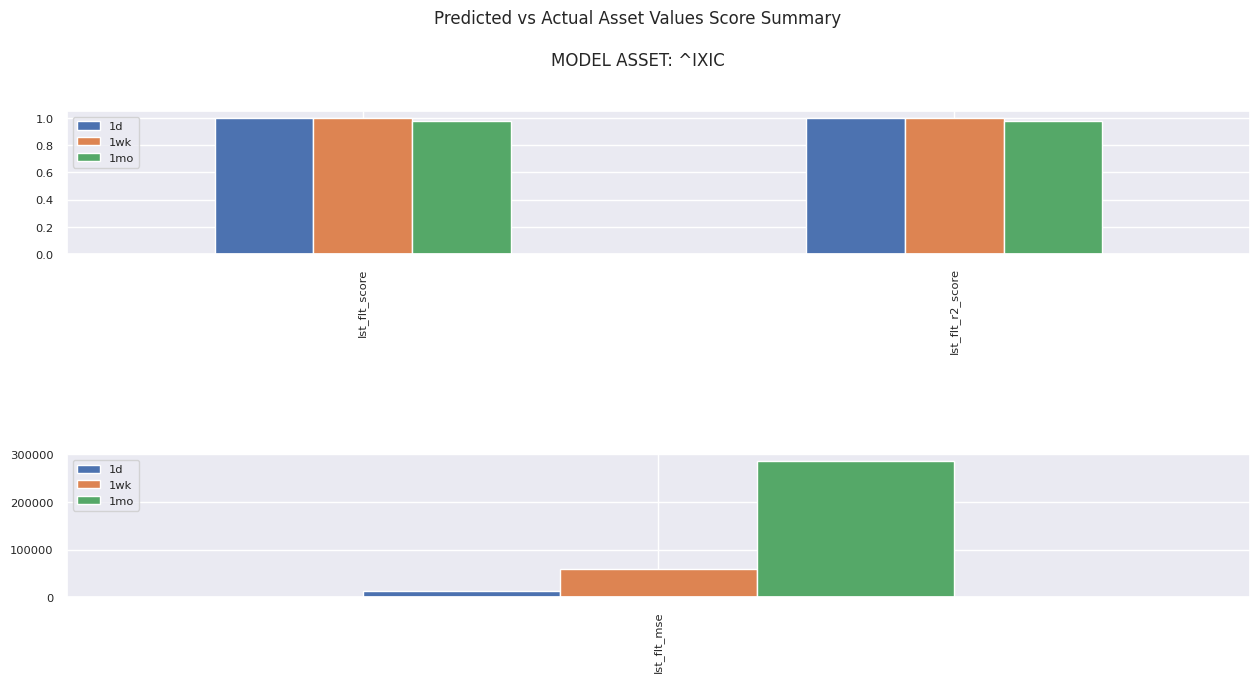


 

None


In [17]:
AssetData(str_co_ticker_1).run_mlr_model_list([str_co_ticker_1, str_co_ticker_2])